In [1]:

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split



import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import albumentations as A # augmentation library
import time
from datetime import datetime
import torchvision.transforms as transforms


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

CUDA available: True
Device name: Tesla P100-PCIE-16GB


In [3]:
%%writefile losses_and_edges.py
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np

_bce = nn.BCEWithLogitsLoss(reduction="none")

def dice_loss_from_logits(logits, y, eps=1e-6):
    p = torch.sigmoid(logits).float()
    y = y.float()
    num = 2.0 * (p * y).sum(dim=(1,2,3))
    den = (p + y).sum(dim=(1,2,3)).clamp_min(eps)
    return 1.0 - (num / den).mean()

def bce_dice_loss(logits, y, alpha=0.5, weight=None):
    bce = _bce(logits, y.float())
    if weight is not None:
        bce = bce * weight
    bce = bce.mean()
    dl  = dice_loss_from_logits(logits, y)
    return alpha * bce + (1.0 - alpha) * dl

def edge_map_from_mask(gt, radius=1):
    pad = radius
    dil = F.max_pool2d(gt, kernel_size=2*radius+1, stride=1, padding=pad)
    ero = -F.max_pool2d(1.0-gt, kernel_size=2*radius+1, stride=1, padding=pad) + 1.0
    edges = (dil - ero).clamp(min=0.0, max=1.0)
    edges = (edges > 0).float()
    return edges

def make_edge_weight_map(gt, edge_radius=1, edge_multiplier=4.0):
    edges = edge_map_from_mask(gt, radius=edge_radius)
    return 1.0 + (edge_multiplier - 1.0) * edges

def _compute_sdf_2d(mask):
    import cv2
    mask = mask.astype(np.uint8)
    posmask = mask
    negmask = 1 - mask
    dist_out = cv2.distanceTransform(negmask, distanceType=cv2.DIST_L2, maskSize=3)
    dist_in  = cv2.distanceTransform(posmask, distanceType=cv2.DIST_L2, maskSize=3)
    sdf = dist_in - dist_out
    return sdf

def sdm_from_batch(gt):
    g = gt.detach().cpu().numpy()
    sdfs = []
    for b in range(g.shape[0]):
        sdfs.append(_compute_sdf_2d(g[b,0]))
    s = np.stack(sdfs, axis=0).astype(np.float32)
    return torch.from_numpy(s).unsqueeze(1).to(gt.device)

class BoundaryLoss(nn.Module):
    def __init__(self, reduction="mean"):
        super().__init__()
        self.reduction = reduction
    def forward(self, logits, gt):
        probs = torch.sigmoid(logits)
        sdm   = sdm_from_batch(gt).abs()
        loss  = (probs * sdm)
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

class BCEDiceBoundaryLoss(nn.Module):
    def __init__(self, alpha=0.5, lambda_boundary=1.0, edge_radius=1, edge_multiplier=1.0):
        super().__init__()
        self.alpha = alpha
        self.lambda_boundary = lambda_boundary
        self.edge_radius = edge_radius
        self.edge_multiplier = edge_multiplier
        self.boundary_loss = BoundaryLoss()
    def forward(self, logits, y):
        weight = None
        if self.edge_multiplier > 1.0 and self.edge_radius > 0:
            with torch.no_grad():
                weight = make_edge_weight_map((y>0.5).float(), self.edge_radius, self.edge_multiplier)
        base = bce_dice_loss(logits, y, alpha=self.alpha, weight=weight)
        bl   = self.boundary_loss(logits, (y>0.5).float())
        return base + self.lambda_boundary * bl

def boundary_f1(pred_bin, gt_bin, tolerance=2):
    import cv2
    pred_bin = pred_bin.astype(np.uint8)
    gt_bin   = gt_bin.astype(np.uint8)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    gt_edge   = cv2.morphologyEx(gt_bin,   cv2.MORPH_GRADIENT, k)
    pred_edge = cv2.morphologyEx(pred_bin, cv2.MORPH_GRADIENT, k)
    if tolerance > 0:
        ktol = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*tolerance+1, 2*tolerance+1))
        gt_band = cv2.dilate(gt_edge, ktol)
        pred_band = cv2.dilate(pred_edge, ktol)
    else:
        gt_band = gt_edge
        pred_band = pred_edge
    tp1 = (pred_edge & gt_band).sum()
    tp2 = (gt_edge & pred_band).sum()
    tp = 0.5*(tp1 + tp2)
    p  = max(int(pred_edge.sum()), 1)
    r  = max(int(gt_edge.sum()), 1)
    precision = float(tp) / float(p)
    recall    = float(tp) / float(r)
    f1 = 0.0 if (precision+recall)==0 else 2*precision*recall/(precision+recall)
    return f1


Writing losses_and_edges.py


In [4]:
import numpy as np, torch, cv2, os
from torch.utils.data import Dataset, DataLoader

# si subiste el archivo que te pasé:
from losses_and_edges import BCEDiceBoundaryLoss, boundary_f1

# --- Normalización robusta por imagen ---
def robust_minmax(img, lo=2, hi=98):
    img = img.astype(np.float32)
    p_lo, p_hi = np.percentile(img, [lo, hi])
    if p_hi <= p_lo:
        return (img - img.min()) / (img.max() - img.min() + 1e-6)
    img = np.clip(img, p_lo, p_hi)
    img = (img - p_lo) / (p_hi - p_lo + 1e-6)
    return img


## Data Preprocessing

The raw image and mask datasets were stored in HDF5 (.h5) format. These were loaded, resized to a standard resolution of 256x256 pixels, and saved as NumPy arrays (.npy) for efficient access and memory usage. Both grayscale images and binary masks were normalized to the range [0, 1].

This preprocessing pipeline ensures consistency across the models and reduces computational requirements during training and evaluation.


In [5]:
import os

print(os.listdir("/kaggle/input/tem-images-and-masks/datasets"))




['Labels', 'Images']


In [6]:
import h5py
import numpy as np
import os;
from skimage.transform import resize

data_dir_images = "/kaggle/input/tem-images-and-masks/datasets/Images"
data_dir_labels = "/kaggle/input/tem-images-and-masks/datasets/Labels"
resize_shape = (256, 256)

X_list, Y_list = [], []

# List all H5 files
image_files = sorted([f for f in os.listdir(data_dir_images) if f.endswith(".h5")])
mask_files = sorted([f for f in os.listdir(data_dir_labels) if f.endswith(".h5")])

for img_file in image_files:
    base_name = img_file.replace("_Images.h5", "")
    mask_file = f"{base_name}_Labels.h5"
    
    if mask_file in mask_files:
        try:
            with h5py.File(os.path.join(data_dir_images, img_file), 'r') as f:
                images = np.array(f[list(f.keys())[0]])
            with h5py.File(os.path.join(data_dir_labels, mask_file), 'r') as f:
                masks = np.array(f[list(f.keys())[0]])
            
            resized_images = np.array([
                resize(img, resize_shape, preserve_range=True, anti_aliasing=True)
                for img in images
            ])
            resized_masks = np.array([
                resize(msk, resize_shape, preserve_range=True, anti_aliasing=True)
                for msk in masks
            ])
            
            X_list.append(resized_images)
            Y_list.append(resized_masks)
            
            print(f"✅ Processed {img_file}")
        except Exception as e:
            print(f"❌ Error processing {img_file}: {e}")
    else:
        print(f"⚠️ Missing mask file for {img_file}")

# Combine and save
X = np.concatenate(X_list, axis=0)
Y = np.concatenate(Y_list, axis=0)

np.save("/kaggle/working/X.npy", X)
np.save("/kaggle/working/Y.npy", Y)

✅ Processed Ag_5nm_330kx_423e_Std_UTC_FFCorr_Team05_Images.h5
✅ Processed Au_10nm_330kx_425e_Std_UTC_FFCorr_Team05_Images.h5
✅ Processed Au_2p2nm_330kx_423e_Std_UTC_FFCorr_Team05_Images.h5
✅ Processed Au_5nm_160kx_425e_Std_UTC_FFCorr_Team05_Images.h5
✅ Processed Au_5nm_205kx_420e_Std_UTC_FFCorr_Team05_Images.h5
✅ Processed Au_5nm_260kx_450e_Std_UTC_FFCorr_Team05_Images.h5
✅ Processed Au_5nm_330kx_421e_UTC_Team05_Std_Sess1109FFCorr_Images.h5
✅ Processed Au_5nm_330kx_423e_UTC_Team05_Std_Sess0821FFCorr_Images.h5
✅ Processed Au_5nm_330kx_423e_UTC_Team05_Std_Sess1006FFCorr_Images.h5
✅ Processed Au_5nm_330kx_425e_UTC_Team05_Std_Sess1025FFCorr_Images.h5
✅ Processed Au_5nm_330kx_80e_Std_UTC_FFCorr_Team05_Images.h5
✅ Processed Au_5nm_330kx_884e_Std_UTC_FFCorr_Team05_Images.h5
✅ Processed CdSe_5nm_330kx_421e_Std_UTC_FFCorr_Team05_Images.h5


In [7]:
class NPYDataset(Dataset):
    def __init__(self, X, Y, resize_shape=(256,256), mean=0.5, std=0.25, augment=False):
        self.X, self.Y = X, Y
        self.resize_shape = resize_shape
        self.mean, self.std = mean, std
        self.augment = augment

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]; msk = self.Y[idx]
        if img.ndim == 3: img = img[...,0]
        if msk.ndim == 3: msk = msk[...,0]

        # 1) per-image robust minmax
        img = robust_minmax(img)
        # 2) resize
        img = cv2.resize(img, self.resize_shape, interpolation=cv2.INTER_LINEAR)
        msk = cv2.resize(msk, self.resize_shape, interpolation=cv2.INTER_NEAREST)

        # 3) augment (solo en train)
        if self.augment and np.random.rand() < 0.5:
            img  = np.fliplr(img).copy()
            msk  = np.fliplr(msk).copy()

        # 4) z-score con mean/std globales (de TRAIN)
        img = (img - self.mean) / (self.std + 1e-6)

        # tensores (1,H,W)
        img_t = torch.from_numpy(img[None].astype(np.float32))
        msk_t = torch.from_numpy((msk > 0).astype(np.float32)[None])
        return img_t, msk_t


In [8]:
X = np.load("/kaggle/working/X.npy")
Y = np.load("/kaggle/working/Y.npy")

print(f"✅ Loaded: X shape = {X.shape}, Y shape = {Y.shape}")



✅ Loaded: X shape = (3154, 256, 256), Y shape = (3154, 256, 256)


# Data Split

In [9]:

from sklearn.model_selection import train_test_split

DATA_DIR = "/kaggle/working/"

# 1) Load data
X = np.load(f"{DATA_DIR}/X.npy")  # (N,H,W) or (N,H,W,1)
Y = np.load(f"{DATA_DIR}/Y.npy")  # (N,H,W) or (N,H,W,1)

# (Optional) If masks are in 0–255, binarize to 0/1:
# Y = (Y > 127).astype(np.uint8)

# 2) Split into 80% train and 20% temp
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)

# 3) Split the 20% temp into 10% validation and 10% test
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, shuffle=True
)

# 4) Check the shapes
print("Train:", X_train.shape, Y_train.shape)
print("Val:  ", X_val.shape,   Y_val.shape)
print("Test: ", X_test.shape,  Y_test.shape)

# 5) Save to disk
np.save(f"{DATA_DIR}/X_train.npy", X_train)
np.save(f"{DATA_DIR}/Y_train.npy", Y_train)
np.save(f"{DATA_DIR}/X_val.npy",   X_val)
np.save(f"{DATA_DIR}/Y_val.npy",   Y_val)
np.save(f"{DATA_DIR}/X_test.npy",  X_test)
np.save(f"{DATA_DIR}/Y_test.npy",  Y_test)

print("✔️ 80/10/10 splits saved in", DATA_DIR)

Train: (2523, 256, 256) (2523, 256, 256)
Val:   (315, 256, 256) (315, 256, 256)
Test:  (316, 256, 256) (316, 256, 256)
✔️ 80/10/10 splits saved in /kaggle/working/


[INFO] Global min/max = -6.7364 / 16.3787


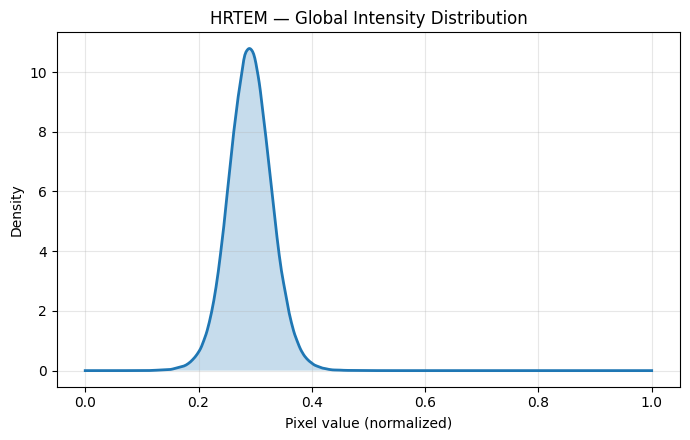

✅ Guardado: /kaggle/working/hrtem_density.png


In [10]:
import numpy as np, matplotlib.pyplot as plt, time, os

# --- Normalización global a [0,1] usando min/max del dataset completo ---
def normalize01_global(arr, gmin=None, gmax=None):
    if gmin is None: gmin = float(np.nanmin(arr))
    if gmax is None: gmax = float(np.nanmax(arr))
    eps = 1e-12
    out = (arr.astype(np.float32) - gmin) / max(gmax - gmin, eps)
    return np.clip(out, 0.0, 8.0), gmin, gmax

# Carga si ya guardaste los splits; si ya tienes X en RAM, usa X directamente
X_all = np.concatenate([X_train, X_val, X_test], axis=0)

# Normaliza global
Xn, gmin, gmax = normalize01_global(X_all)
print(f"[INFO] Global min/max = {gmin:.4f} / {gmax:.4f}")

# Muestreo de píxeles para acelerar
rng = np.random.default_rng(0)
flat = Xn.reshape(-1)
N = min(len(flat), 400_000)        # ~0.4M píxeles dan una curva suave
pixels = rng.choice(flat, size=N, replace=False)

# KDE si tienes scipy; sino, histograma con densidad
def plot_density(values, title, outpath):
    try:
        from scipy.stats import gaussian_kde
        xs = np.linspace(0,1,512)
        kde = gaussian_kde(values)
        ys = kde(xs)
        plt.figure(figsize=(7,4.5))
        plt.plot(xs, ys, linewidth=2)
        plt.fill_between(xs, ys, alpha=0.25)
    except Exception as e:
        print(f"[WARN] KDE no disponible ({e}). Uso histograma.")
        plt.figure(figsize=(7,4.5))
        plt.hist(values, bins=256, range=(0,1), density=True, alpha=0.7)

    plt.xlabel("Pixel value (normalized)"); plt.ylabel("Density")
    plt.title(title); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(outpath, dpi=150); plt.show()

out = "/kaggle/working/hrtem_density.png"
plot_density(pixels, "HRTEM — Global Intensity Distribution", out)
print("✅ Guardado:", out)

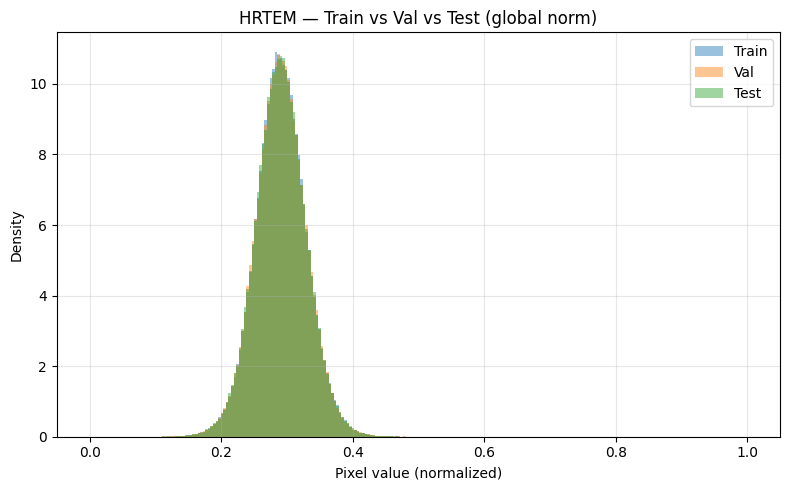

✅ Guardado: /kaggle/working/hrtem_splits_density.png


In [11]:
import numpy as np, matplotlib.pyplot as plt

# Normalización global usando todo el dataset
X_all = np.concatenate([X_train, X_val, X_test], axis=0)
def normalize01(arr, lo, hi):
    eps = 1e-12
    out = (arr.astype(np.float32) - lo) / max(hi - lo, eps)
    return np.clip(out, 0.0, 1.0)

gmin, gmax = float(np.nanmin(X_all)), float(np.nanmax(X_all))
Xtr = normalize01(X_train, gmin, gmax).reshape(-1)
Xva = normalize01(X_val,   gmin, gmax).reshape(-1)
Xte = normalize01(X_test,  gmin, gmax).reshape(-1)

# Muestrea para cada split
rng = np.random.default_rng(0)
def samp(x, n=250_000):
    n = min(len(x), n); return rng.choice(x, size=n, replace=False)

tr = samp(Xtr); va = samp(Xva); te = samp(Xte)

# Dibuja con histograma (robusto); si prefieres KDE, puedes llamarlo como en A)
plt.figure(figsize=(8,5))
plt.hist(tr, bins=256, range=(0,1), density=True, alpha=0.45, label="Train")
plt.hist(va, bins=256, range=(0,1), density=True, alpha=0.45, label="Val")
plt.hist(te, bins=256, range=(0,1), density=True, alpha=0.45, label="Test")
plt.xlabel("Pixel value (normalized)"); plt.ylabel("Density")
plt.title("HRTEM — Train vs Val vs Test (global norm)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
out = "/kaggle/working/hrtem_splits_density.png"
plt.savefig(out, dpi=150); plt.show()
print("✅ Guardado:", out)

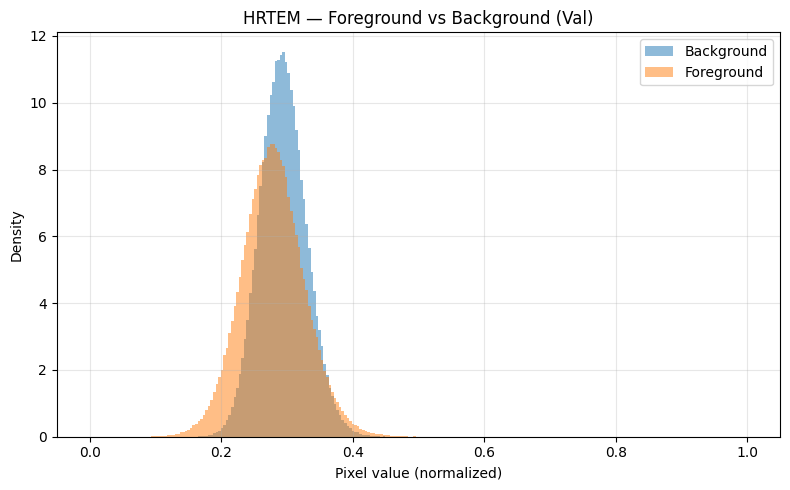

✅ Guardado: /kaggle/working/hrtem_fg_bg_density.png


In [12]:
import numpy as np, matplotlib.pyplot as plt

# Normaliza X_val globalmente (mismo gmin/gmax que uses en el reporte)
X_all = np.concatenate([X_train, X_val, X_test], axis=0)
gmin, gmax = float(np.nanmin(X_all)), float(np.nanmax(X_all))
eps = 1e-12
Xv = np.clip((X_val.astype(np.float32)-gmin)/max(gmax-gmin, eps), 0, 1)

# Umbral de máscara a binario (ajusta si tus Y ya son 0/1)
Yv = (Y_val > 0.5).astype(np.uint8)

# Separa pixeles
fg = Xv[Yv==1].reshape(-1)
bg = Xv[Yv==0].reshape(-1)

# Muestrea para rapidez
rng = np.random.default_rng(1)
fg = rng.choice(fg, size=min(len(fg), 300_000), replace=False)
bg = rng.choice(bg, size=min(len(bg), 300_000), replace=False)

# Grafica
plt.figure(figsize=(8,5))
plt.hist(bg, bins=256, range=(0,1), density=True, alpha=0.5, label="Background")
plt.hist(fg, bins=256, range=(0,1), density=True, alpha=0.5, label="Foreground")
plt.xlabel("Pixel value (normalized)"); plt.ylabel("Density")
plt.title("HRTEM — Foreground vs Background (Val)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
out = "/kaggle/working/hrtem_fg_bg_density.png"
plt.savefig(out, dpi=150); plt.show()
print("✅ Guardado:", out)

In [13]:
# calcula mean/std post robust_minmax sobre train (muestra para acelerar si hace falta)
sample = X_train if len(X_train) <= 500 else X_train[:500]
Xm = np.stack([robust_minmax(x[...,0] if x.ndim==3 else x) for x in sample], 0)
MEAN, STD = float(Xm.mean()), float(Xm.std())
print(f"[Norm] mean={MEAN:.4f}, std={STD:.4f} (post robust_minmax, train only)")


[Norm] mean=0.4912, std=0.2315 (post robust_minmax, train only)


In [14]:
import numpy as np

# Cargar train ya splitteado
X_train = np.load("/kaggle/working/X_train.npy")

def robust_minmax(img, lo=2, hi=98):
    img = img.astype(np.float32)
    p_lo, p_hi = np.percentile(img, [lo, hi])
    if p_hi <= p_lo:
        return (img - img.min()) / (img.max() - img.min() + 1e-6)
    img = np.clip(img, p_lo, p_hi)
    img = (img - p_lo) / (p_hi - p_lo + 1e-6)
    return img

# Calcular mean/std en train (post robust_minmax). Muestra para acelerar si es grande:
sample = X_train if len(X_train) <= 500 else X_train[:500]
Xm = np.stack([robust_minmax(x[...,0] if x.ndim==3 else x) for x in sample], 0)
MEAN, STD = float(Xm.mean()), float(Xm.std())
print(f"[Norm] mean={MEAN:.4f}, std={STD:.4f} (post robust_minmax, solo TRAIN)")


[Norm] mean=0.4912, std=0.2315 (post robust_minmax, solo TRAIN)


In [15]:
import numpy as np

# Cargar train ya splitteado
X_train = np.load("/kaggle/working/X_train.npy")

def robust_minmax(img, lo=2, hi=98):
    img = img.astype(np.float32)
    p_lo, p_hi = np.percentile(img, [lo, hi])
    if p_hi <= p_lo:
        return (img - img.min()) / (img.max() - img.min() + 1e-6)
    img = np.clip(img, p_lo, p_hi)
    img = (img - p_lo) / (p_hi - p_lo + 1e-6)
    return img

# Calcular mean/std en train (post robust_minmax). Muestra para acelerar si es grande:
sample = X_train if len(X_train) <= 500 else X_train[:500]
Xm = np.stack([robust_minmax(x[...,0] if x.ndim==3 else x) for x in sample], 0)
MEAN, STD = float(Xm.mean()), float(Xm.std())
print(f"[Norm] mean={MEAN:.4f}, std={STD:.4f} (post robust_minmax, solo TRAIN)")


[Norm] mean=0.4912, std=0.2315 (post robust_minmax, solo TRAIN)


In [16]:
X_train = np.load("/kaggle/working/X_train.npy")
Y_train = np.load("/kaggle/working/Y_train.npy")
X_val   = np.load("/kaggle/working/X_val.npy")
Y_val   = np.load("/kaggle/working/Y_val.npy")

train_ds = NPYDataset(X_train, Y_train, resize_shape=resize_shape, mean=MEAN, std=STD, augment=True)
val_ds   = NPYDataset(X_val,   Y_val,   resize_shape=resize_shape, mean=MEAN, std=STD, augment=False)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)


In [17]:
# Si subiste el archivo que te pasé:
from losses_and_edges import BCEDiceBoundaryLoss, boundary_f1

criterion = BCEDiceBoundaryLoss(
    alpha=0.5,            # peso BCE en BCE+Dice
    lambda_boundary=1.0,  # λ del Boundary Loss (podés subir a 2.0)
    edge_radius=1,        # radio px para mapa de borde
    edge_multiplier=4.0   # peso ×4 en BCE para píxeles de borde
)


## Data Augmentation Strategy

To improve model generalization and prevent overfitting, we applied a customized data augmentation pipeline using the Albumentations library. These augmentations simulate realistic variations observed in transmission electron microscopy (TEM) images of nanoparticles.

The transformations included:

- **Horizontal and Vertical Flip (p=0.5)**: Introduces spatial variability by flipping images along the X and Y axes.
- **Random Rotation (±20°, p=0.5)**: Helps models learn rotational invariance common in nanoparticle imaging.
- **Affine Transformation (p=0.5)**:
  - Translation up to ±5% of the image size
  - Fixed scale of 105% to simulate zoom-in effects
- **Random Brightness and Contrast (p=0.3)**: Simulates lighting or exposure changes in microscopy.
- **Gaussian Noise (p=0.3)**: Mimics sensor noise typically found in TEM imaging systems.
- **Blurring (p=0.2)**: Introduces slight defocus to represent imaging imperfections.

These augmentations were applied to both input images and their corresponding segmentation masks to maintain spatial consistency.

This augmentation strategy increases data diversity and encourages the models to learn more robust features under varying imaging conditions.


In [18]:
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A

# 1) Augmentación estilo "imgaug": rot/flip o blur gaussiano en ~50% del batch
train_aug_imgaug_like = A.OneOf([
    A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=180, border_mode=0, p=0.5),  # 0=const (negro) en bordes
    ]),
    A.GaussianBlur(blur_limit=(1, 21), sigma_limit=(0, 3.0), p=1.0),  # solo afecta a image (no a mask)
], p=0.5)

# 2) Dataset de segmentación que usa la aug cuando augment=True
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, augment=False, aug=None):
        """
        images: array/list con HxW, HxWx1 o HxWx3 (o CHW, también lo soporta)
        masks : array/list con HxW o HxWx1 (binaria o umbralizable)
        augment: si True, aplica 'aug' (o train_aug_imgaug_like por defecto)
        aug: pipeline Albumentations. Si None y augment=True, usa train_aug_imgaug_like
        """
        self.images = images
        self.masks  = masks
        self.augment = augment
        self.aug = aug if aug is not None else train_aug_imgaug_like

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = np.asarray(self.images[idx])
        msk = np.asarray(self.masks[idx])

        # ---- Asegurar HWC para Albumentations ----
        # Imagen
        if img.ndim == 2:                       # H,W -> H,W,1
            img = img[..., None]
        elif img.ndim == 3 and img.shape[0] in (1,3) and img.shape[-1] not in (1,3):  # CHW -> HWC
            img = np.transpose(img, (1,2,0))
        # Máscara
        if msk.ndim == 2:
            msk = msk[..., None]
        elif msk.ndim == 3 and msk.shape[0] == 1 and msk.shape[-1] != 1:              # CHW -> HWC
            msk = np.transpose(msk, (1,2,0))

        # ---- Normalizar imagen a [0,1] ----
        img = img.astype(np.float32)
        if img.max() > 1.0:
            img /= 255.0

        # ---- Binarizar máscara a {0,1} sin perder forma ----
        msk = msk.astype(np.float32)
        if msk.max() > 1.0:
            msk = (msk > 127).astype(np.float32)
        else:
            msk = (msk > 0.5).astype(np.float32)

        # ---- Aplicar augmentación si corresponde ----
        if self.augment and self.aug is not None:
            out = self.aug(image=img, mask=msk)
            img, msk = out["image"], out["mask"]

        # ---- Volver a CHW para PyTorch ----
        img = np.transpose(img, (2,0,1)).astype(np.float32)  # (C,H,W)
        msk = np.transpose(msk, (2,0,1)).astype(np.float32)  # (1,H,W) binaria

        return torch.tensor(img, dtype=torch.float32), torch.tensor(msk, dtype=torch.float32)


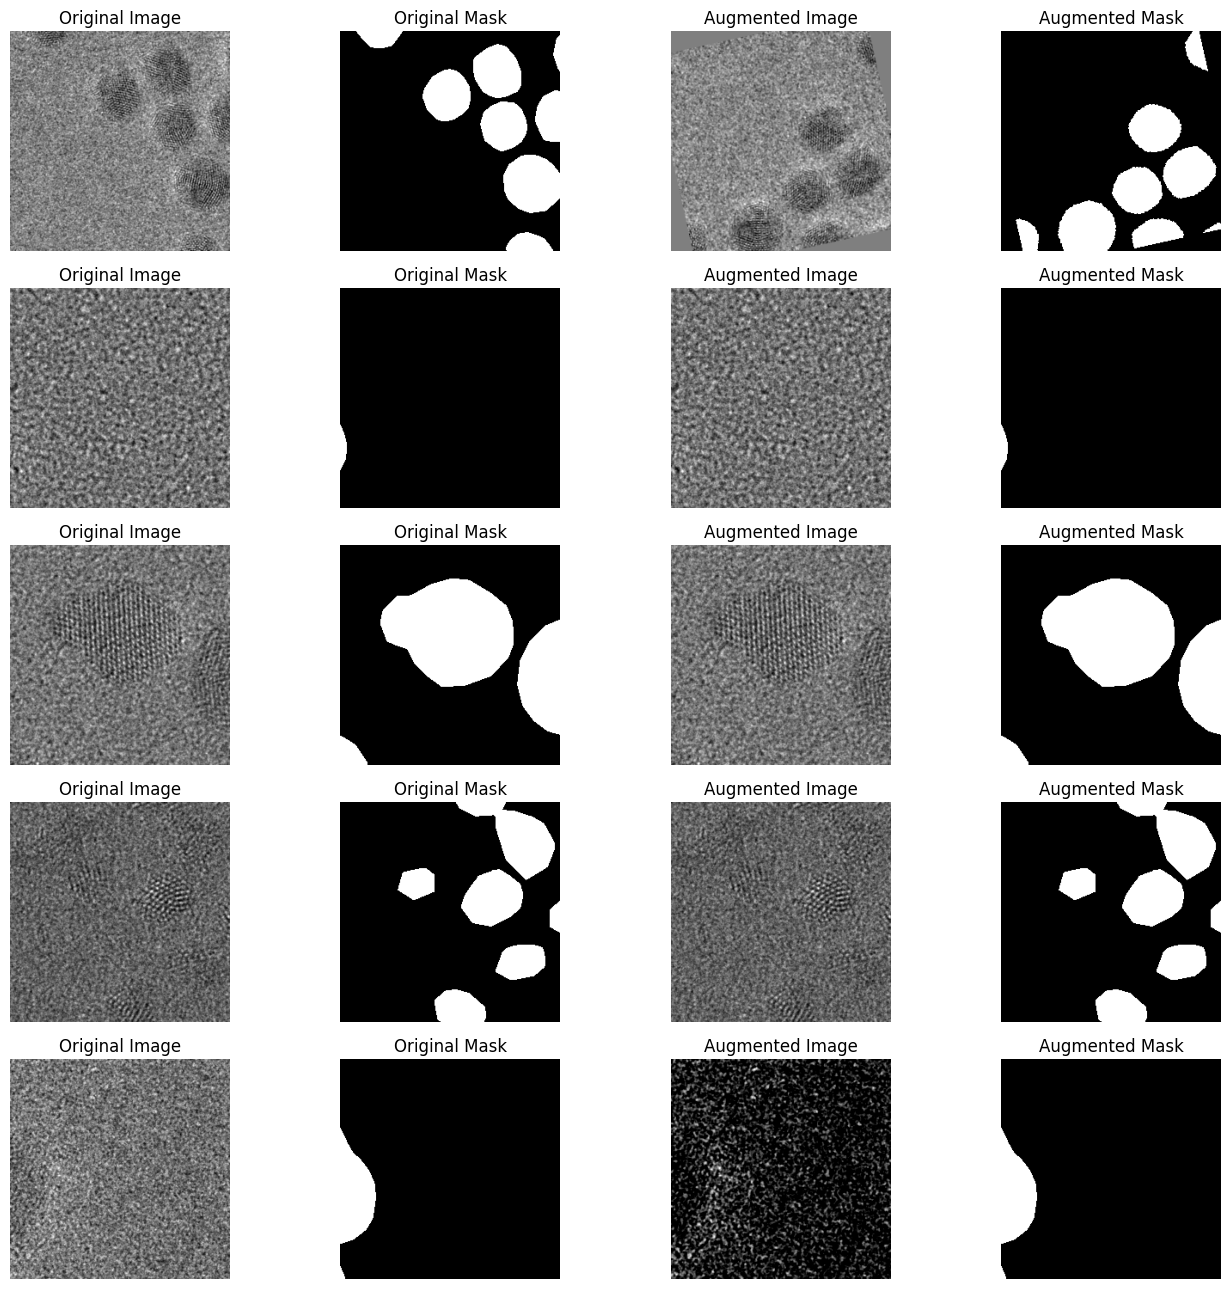

In [19]:
# 5. Visualization (change X_train, Y_train to the actual data)
def _to_gray_2d(arr):
    """Convierte HxW, HxWx1/3 o 1/3xHxW a HxW (grayscale) para mostrar."""
    arr = np.asarray(arr)
    # CHW -> HWC si aplica
    if arr.ndim == 3 and arr.shape[0] in (1,3) and arr.shape[-1] not in (1,3):
        arr = np.transpose(arr, (1,2,0))
    # HWC: colapsar canales
    if arr.ndim == 3 and arr.shape[-1] == 3:
        arr = 0.2989*arr[...,0] + 0.5870*arr[...,1] + 0.1140*arr[...,2]
    elif arr.ndim == 3 and arr.shape[-1] == 1:
        arr = arr[...,0]
    return np.squeeze(arr)

num_samples = 5
apply_augmentation = True

sample_dataset = SegmentationDataset(X_train, Y_train, augment=apply_augmentation)

plt.figure(figsize=(14, num_samples * 2.6))

for i in range(num_samples):
    # --- original ---
    x_orig = X_train[i]
    y_orig = Y_train[i]
    img_orig = _to_gray_2d(x_orig)
    msk_orig = _to_gray_2d(y_orig) > 0.5  # binariza para visualizar
    msk_orig = msk_orig.astype(np.uint8) * 255

    # --- augmented (del dataset con augment=apply_augmentation) ---
    x_aug, y_aug = sample_dataset[i]
    if isinstance(x_aug, torch.Tensor): x_aug = x_aug.detach().cpu().numpy()
    if isinstance(y_aug, torch.Tensor): y_aug = y_aug.detach().cpu().numpy()
    img_aug = _to_gray_2d(x_aug)
    msk_aug = (_to_gray_2d(y_aug) > 0.5).astype(np.uint8) * 255

    # Fila i -> 4 columnas
    r = i
    # Original Image
    plt.subplot(num_samples, 4, 4*r + 1)
    plt.imshow(img_orig, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Original Mask
    plt.subplot(num_samples, 4, 4*r + 2)
    plt.imshow(msk_orig, cmap='gray')
    plt.title("Original Mask")
    plt.axis('off')

    # Augmented Image
    plt.subplot(num_samples, 4, 4*r + 3)
    plt.imshow(img_aug, cmap='gray')
    plt.title("Augmented Image" if apply_augmentation else "Original Image")
    plt.axis('off')

    # Augmented Mask
    plt.subplot(num_samples, 4, 4*r + 4)
    plt.imshow(msk_aug, cmap='gray')
    plt.title("Augmented Mask" if apply_augmentation else "Original Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Models Overview

In this study, we compare four semantic segmentation approaches:

1. **U-Net**: A classical encoder-decoder convolutional architecture widely used in biomedical image segmentation.
2. **SegNet**: A VGG-based model using max-pooling indices in the decoder to preserve spatial information.
3. **Attention U-Net**: An extension of U-Net that incorporates attention gates to enhance relevant spatial features.
4. **Segment Anything (SAM)**:
   - **Zero-shot (without guidance)**: Evaluates the out-of-the-box performance of SAM using its automatic mask generation without any supervision.
   - **Fine-tuned SAM**: Uses SAM’s encoder (ViT) as a frozen feature extractor, with a trainable U-Net-style decoder trained on the custom dataset.

The goal is to assess how a pre-trained foundation model like SAM performs compared to classic supervised models, and whether task-specific fine-tuning improves its performance on domain-specific scientific images.


## U-Net (base)

| Code name | Description | Conceptual role |
|-----------|-------------|-----------------|
| `self.enc1 = self.conv_block(in_channels, 64)` | Two 3×3 convs + ReLU. Initial feature extraction. | Encoder level 1 |
| `self.enc2 = self.conv_block(64, 128)` | Deeper features, doubles channels. | Encoder level 2 |
| `self.enc3 = self.conv_block(128, 256)` | Higher-level features. | Encoder level 3 |
| `self.enc4 = self.conv_block(256, 512)` | Deepest encoder stage before bottleneck. | Encoder level 4 |
| `self.bottleneck = self.conv_block(512, 1024)` | Most abstract representation. | Bottleneck |
| `self.upconv4 = nn.Upsample(scale_factor=2, ...)` | 2× upsampling from bottleneck scale. | Decoder upsample (level 4) |
| `self.dec4 = self.conv_block(1024 + 512, 512)` | Convs after concatenating skip from `enc4`. | Decoder level 4 |
| `self.upconv3` / `self.dec3` | 2× upsample; convs after skip from `enc3`. | Decoder level 3 |
| `self.upconv2` / `self.dec2` | 2× upsample; convs after skip from `enc2`. | Decoder level 2 |
| `self.upconv1` / `self.dec1` | 2× upsample; convs after skip from `enc1`. | Decoder level 1 |
| `self.output_layer = nn.Conv2d(64, out_channels, 1)` | Final 1×1 conv to map to classes; typically followed by `sigmoid`. | Output layer |
| `conv_block(in_ch, out_ch)` | Helper: `Conv3×3 → ReLU → Conv3×3 → ReLU`. | Building block |

---

## Attention U-Net

| Code name | Description | Conceptual role |
|-----------|-------------|-----------------|
| `self.enc1..enc4`, `self.bottleneck` | Same as base U-Net. | Encoder + bottleneck |
| `self.upconv4`, `self.dec4`, `self.upconv3`, `self.dec3`, `self.upconv2`, `self.dec2`, `self.upconv1`, `self.dec1` | Same decoder scaffold as U-Net. | Decoder |
| `self.att4 = AttentionGate(1024, 512, 256)` | Gated skip for level 4: gates encoder features (`F_l=512`) with decoder gating signal (`F_g=1024→upsampled`). | Attention gate L4 |
| `self.att3 = AttentionGate(512, 256, 128)` | Gated skip for level 3. | Attention gate L3 |
| `self.att2 = AttentionGate(256, 128, 64)` | Gated skip for level 2. | Attention gate L2 |
| `self.att1 = AttentionGate(128, 64, 32)` | Gated skip for level 1. | Attention gate L1 |
| `AttentionGate` internals | `1×1 conv + BN` on `g` and `x`, sum → nonlinearity → `1×1 conv + BN + Sigmoid` to produce attention mask, elementwise multiply with skip features. | Additive attention on skips |
| `self.output_layer` | Final 1×1 conv + `sigmoid`. | Output layer |

---

## SegNet

| Code name | Description | Conceptual role |
|-----------|-------------|-----------------|
| `self.enc1 = self.conv_block(in_channels, 64)` | Convolutional block at input resolution. | Encoder stage 1 |
| `self.pool1 = nn.MaxPool2d(2, 2)` | Downsample ×2. | Encoder downsample 1 |
| `self.enc2 = self.conv_block(64, 128)` | Convolutional block after downsample. | Encoder stage 2 |
| `self.pool2 = nn.MaxPool2d(2, 2)` | Downsample ×2. | Encoder downsample 2 |
| `self.enc3 = self.conv_block(128, 256)` | Deeper conv block. | Encoder stage 3 |
| `self.pool3 = nn.MaxPool2d(2, 2)` | Downsample ×2 (deepest). | Encoder downsample 3 |
| `self.up3 = nn.Upsample(scale_factor=2, ...)` | Upsample to mirror `pool3`. | Decoder upsample 3 |
| `self.dec3 = self.conv_block(256, 128)` | Convs to refine after upsample. | Decoder stage 3 |
| `self.up2` / `self.dec2` | Upsample to mirror `pool2`; refine features. | Decoder stage 2 |
| `self.up1` / `self.dec1` | Upsample to mirror `pool1`; refine features. | Decoder stage 1 |
| `self.output_layer = nn.Conv2d(64, out_channels, 1)` | Final classifier conv; typically followed by `sigmoid`. | Output layer |
| `conv_block(in_ch, out_ch)` | Helper used for both encoder/decoder convs. | Building block |

*Note:* This SegNet variant uses simple bilinear `Upsample` + convs (not max-pooling indices); functionally it’s a symmetric encoder–decoder without explicit skip concatenations.

---

## SAMDecoderUNet (decoder head for SAM encoder)

| Code name | Description | Conceptual role |
|-----------|-------------|-----------------|
| `self.encoder` | Pretrained SAM encoder (e.g., ViT-B) producing feature map ~`[B, 256, 64, 64]` for 1024-px long side inputs. | Frozen / reused encoder |
| `self.up1 = nn.Sequential(Conv2d(256,128,3,pad=1) → ReLU → Upsample×2)` | First upsampling & channel reduction. | Decoder stage 1 |
| `self.up2 = nn.Sequential(Conv2d(128,64,3,pad=1) → ReLU → Upsample×2)` | Second upsampling. | Decoder stage 2 |
| `self.up3 = nn.Sequential(Conv2d(64,32,3,pad=1) → ReLU → Upsample×2)` | Third upsampling. | Decoder stage 3 |
| `self.up4 = nn.Sequential(Conv2d(32,16,3,pad=1) → ReLU → Upsample×2)` | Fourth upsampling to input scale. | Decoder stage 4 |
| `self.final = nn.Conv2d(16, 1, 1)` | Final 1×1 conv to produce logits; usually followed by `sigmoid`. | Output layer |




# U-Net model

In [20]:
# UNet base
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec4 = self.conv_block(1024 + 512, 512)

        self.upconv3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = self.conv_block(512 + 256, 256)

        self.upconv2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = self.conv_block(256 + 128, 128)

        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv_block(128 + 64, 64)

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        c1 = self.enc1(x); p1 = F.max_pool2d(c1, 2)
        c2 = self.enc2(p1); p2 = F.max_pool2d(c2, 2)
        c3 = self.enc3(p2); p3 = F.max_pool2d(c3, 2)
        c4 = self.enc4(p3); p4 = F.max_pool2d(c4, 2)
        c5 = self.bottleneck(p4)

        u6 = self.upconv4(c5); c6 = self.dec4(torch.cat([u6, c4], dim=1))
        u7 = self.upconv3(c6); c7 = self.dec3(torch.cat([u7, c3], dim=1))
        u8 = self.upconv2(c7); c8 = self.dec2(torch.cat([u8, c2], dim=1))
        u9 = self.upconv1(c8); c9 = self.dec1(torch.cat([u9, c1], dim=1))
        return torch.sigmoid(self.output_layer(c9))

# Attention U-Net

In [21]:
# Base UNet block
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec4 = self.conv_block(1024 + 512, 512)

        self.upconv3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = self.conv_block(512 + 256, 256)

        self.upconv2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = self.conv_block(256 + 128, 128)

        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv_block(128 + 64, 64)

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        c1 = self.enc1(x); p1 = F.max_pool2d(c1, 2)
        c2 = self.enc2(p1); p2 = F.max_pool2d(c2, 2)
        c3 = self.enc3(p2); p3 = F.max_pool2d(c3, 2)
        c4 = self.enc4(p3); p4 = F.max_pool2d(c4, 2)

        c5 = self.bottleneck(p4)

        u6 = self.upconv4(c5); c6 = self.dec4(torch.cat([u6, c4], dim=1))
        u7 = self.upconv3(c6); c7 = self.dec3(torch.cat([u7, c3], dim=1))
        u8 = self.upconv2(c7); c8 = self.dec2(torch.cat([u8, c2], dim=1))
        u9 = self.upconv1(c8); c9 = self.dec1(torch.cat([u9, c1], dim=1))

        return torch.sigmoid(self.output_layer(c9))


# Attention Gate block
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


# Corrected Attention UNet
class AttentionUNet(UNet):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__(in_channels, out_channels)

        # Updated attention gates with corrected channel dimensions
        self.att4 = AttentionGate(1024, 512, 256)
        self.att3 = AttentionGate(512, 256, 128)
        self.att2 = AttentionGate(256, 128, 64)
        self.att1 = AttentionGate(128, 64, 32)

    def forward(self, x):
        c1 = self.enc1(x); p1 = F.max_pool2d(c1, 2)
        c2 = self.enc2(p1); p2 = F.max_pool2d(c2, 2)
        c3 = self.enc3(p2); p3 = F.max_pool2d(c3, 2)
        c4 = self.enc4(p3); p4 = F.max_pool2d(c4, 2)
        c5 = self.bottleneck(p4)

        u6 = self.upconv4(c5); a4 = self.att4(g=u6, x=c4); c6 = self.dec4(torch.cat([u6, a4], dim=1))
        u7 = self.upconv3(c6); a3 = self.att3(g=u7, x=c3); c7 = self.dec3(torch.cat([u7, a3], dim=1))
        u8 = self.upconv2(c7); a2 = self.att2(g=u8, x=c2); c8 = self.dec2(torch.cat([u8, a2], dim=1))
        u9 = self.upconv1(c8); a1 = self.att1(g=u9, x=c1); c9 = self.dec1(torch.cat([u9, a1], dim=1))

        return torch.sigmoid(self.output_layer(c9))


# SegNet

In [22]:
class SegNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SegNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = self.conv_block(256, 128)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = self.conv_block(128, 64)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv_block(64, 64)

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.enc1(x)
        p1 = self.pool1(x1)

        x2 = self.enc2(p1)
        p2 = self.pool2(x2)

        x3 = self.enc3(p2)
        p3 = self.pool3(x3)

        up3 = self.up3(p3)
        d3 = self.dec3(up3)

        up2 = self.up2(d3)
        d2 = self.dec2(up2)

        up1 = self.up1(d2)
        d1 = self.dec1(up1)

        out = torch.sigmoid(self.output_layer(d1))
        return out

Training Models

In [23]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=15, min_delta=5e-4, restore_best=True, ckpt_path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.ckpt_path = ckpt_path
        self.best = float("inf")
        self.best_state = None
        self.best_epoch = -1
        self.bad_epochs = 0

    def step(self, val_loss, model, epoch):
        improved = (self.best - val_loss) > self.min_delta
        if improved:
            self.best = val_loss
            self.best_epoch = epoch
            self.bad_epochs = 0
            if self.restore_best:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            if self.ckpt_path:
                torch.save(model.state_dict(), self.ckpt_path)
        else:
            self.bad_epochs += 1
        return self.bad_epochs > self.patience

    def restore(self, model):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict(self.best_state)


def _has_encoder(model):
    return hasattr(model, "encoder") and isinstance(getattr(model, "encoder"), torch.nn.Module)

def _set_requires_grad(module, requires_grad: bool):
    for p in module.parameters():
        p.requires_grad = requires_grad


# Kaggle-ready training loop
def train_model_earlystop(
    model,
    train_data,
    val_data,
    epochs=40,
    batch_size=32,
    lr=2e-4,
    num_workers=None,          # auto-pick if None
    save_path=None,            # default -> /kaggle/working/models/<model>_best...
    patience=15,
    min_delta=5e-4,
    use_reduce_on_plateau=True,
    clip_grad_norm: float | None = 1.0,
    freeze_encoder_epochs: int = 3,
    freeze_bn_in_encoder: bool = True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    X_train, y_train = train_data
    X_val,   y_val   = val_data

    # Externally defined dataset class
    train_ds = SegmentationDataset(X_train, y_train, augment=True)
    val_ds   = SegmentationDataset(X_val,   y_val,   augment=False)

    if num_workers is None:
        num_workers = max(0, (os.cpu_count() or 2) - 1)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        pin_memory=torch.cuda.is_available(), num_workers=num_workers
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size,
        pin_memory=torch.cuda.is_available(), num_workers=num_workers
    )

    # If your model outputs logits, prefer BCEWithLogitsLoss and remove/avoid sigmoid in forward.
    criterion = bce_dice_loss
    optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = None
    if use_reduce_on_plateau:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=max(1, patience//2), verbose=False
        )

    # --- Save path in Kaggle ---
    if save_path is None:
        MODEL_DIR = os.path.join("/kaggle/working", "models")
        os.makedirs(MODEL_DIR, exist_ok=True)
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = type(model).__name__
        save_path = os.path.join(MODEL_DIR, f"{model_name}_best_e{epochs}_{ts}.pt")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    stopper = EarlyStopping(patience=patience, min_delta=min_delta,
                            restore_best=True, ckpt_path=save_path)

    history = {'train_loss': [], 'val_loss': []}
    t0 = time.time()
    print(f"\n🚀 Training with EarlyStopping (patience={patience}, min_delta={min_delta}) on {device}\n")

    # Optional encoder freeze
    encoder_frozen = False
    if freeze_encoder_epochs > 0 and _has_encoder(model):
        _set_requires_grad(model.encoder, False)
        encoder_frozen = True
        if freeze_bn_in_encoder:
            model.encoder.eval()
        print(f"🧊 Encoder frozen for {freeze_encoder_epochs} epochs.")

    for epoch in range(epochs):
        if encoder_frozen and epoch == freeze_encoder_epochs and _has_encoder(model):
            _set_requires_grad(model.encoder, True)
            encoder_frozen = False
            print("🔥 Encoder unfrozen (training full network).")

        # Train
        model.train()
        if freeze_bn_in_encoder and _has_encoder(model) and epoch < freeze_encoder_epochs:
            model.encoder.eval()

        run = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()

            if clip_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)

            optimizer.step()
            run += loss.item()
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
        avg_train = run / max(1, len(train_loader))

        # Val
        model.eval()
        val_sum = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                val_sum += criterion(y_pred, y).item()
        avg_val = val_sum / max(1, len(val_loader))

        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)

        if scheduler is not None:
            scheduler.step(avg_val)

        lr_now = optimizer.param_groups[0]['lr']
        elapsed = time.time() - t0
        eta = (elapsed / (epoch + 1)) * (epochs - epoch - 1)
        freeze_tag = " (encoder FREEZE)" if (freeze_encoder_epochs > 0 and epoch < freeze_encoder_epochs and _has_encoder(model)) else ""
        print(f"✅ Epoch {epoch+1}/{epochs}{freeze_tag} — Train: {avg_train:.4f} — Val: {avg_val:.4f} — LR: {lr_now:.2g} — Elapsed: {elapsed:.1f}s — ETA: {eta:.1f}s")

        if stopper.step(avg_val, model, epoch):
            print(f"⛔ Early stop at epoch {epoch+1}. Best val_loss = {stopper.best:.4f} (epoch {stopper.best_epoch+1})")
            break

    stopper.restore(model)
    print(f"\n💾 Best model saved to: {save_path} (restored in memory)")

    return history


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

✅ Using device: Tesla P100-PCIE-16GB


In [25]:
# Initialize models and send them to GPU (if available)
unet_model = UNet(in_channels=1, out_channels=1).to(device)
attention_model = AttentionUNet(in_channels=1, out_channels=1).to(device)
segnet_model = SegNet(in_channels=1, out_channels=1).to(device)

In [26]:
# --- LOSS: BCE + Dice desde probabilidades (mantén sigmoid en el forward) ---
bce = nn.BCELoss()

def dice_loss_from_probs(probs, y_true, eps=1e-6):
    # probs,y_true: (B,1,H,W) en [0,1]
    num = 2.0 * (probs * y_true).sum(dim=(2,3))
    den = (probs + y_true).sum(dim=(2,3)) + eps
    return (1.0 - (num / den)).mean()

def bce_dice_loss(pred_probs, y_true, alpha=0.5):
    return alpha * bce(pred_probs, y_true) + (1.0 - alpha) * dice_loss_from_probs(pred_probs, y_true)


### Early stopping

In [27]:
history_unet_earlystop = train_model_earlystop(
    unet_model,
    (X_train, Y_train),
    (X_val, Y_val),
    epochs=100,
    batch_size=8,
    lr=2e-4,
    num_workers=4,
    patience=12,          # un poco más agresivo que 15
    min_delta=5e-4,
    use_reduce_on_plateau=True,
    clip_grad_norm=1.0,
    freeze_encoder_epochs=0,   # pon 0 si tu encoder NO es preentrenado
    freeze_bn_in_encoder=False
)



🚀 Training with EarlyStopping (patience=12, min_delta=0.0005) on cuda



Epoch 1/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 1/100 — Train: 0.6676 — Val: 0.6643 — LR: 0.0002 — Elapsed: 79.9s — ETA: 7914.0s


Epoch 2/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 2/100 — Train: 0.6630 — Val: 0.6568 — LR: 0.0002 — Elapsed: 159.6s — ETA: 7819.1s


Epoch 3/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 3/100 — Train: 0.6513 — Val: 0.4357 — LR: 0.0002 — Elapsed: 239.2s — ETA: 7733.5s


Epoch 4/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 4/100 — Train: 0.5668 — Val: 0.3904 — LR: 0.0002 — Elapsed: 318.7s — ETA: 7648.9s


Epoch 5/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 5/100 — Train: 0.5066 — Val: 0.3258 — LR: 0.0002 — Elapsed: 398.3s — ETA: 7567.1s


Epoch 6/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 6/100 — Train: 0.4168 — Val: 0.2384 — LR: 0.0002 — Elapsed: 477.8s — ETA: 7485.6s


Epoch 7/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 7/100 — Train: 0.3529 — Val: 0.2051 — LR: 0.0002 — Elapsed: 557.4s — ETA: 7405.2s


Epoch 8/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 8/100 — Train: 0.3191 — Val: 0.2120 — LR: 0.0002 — Elapsed: 637.0s — ETA: 7325.4s


Epoch 9/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 9/100 — Train: 0.3146 — Val: 0.1994 — LR: 0.0002 — Elapsed: 716.0s — ETA: 7239.7s


Epoch 10/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 10/100 — Train: 0.3024 — Val: 0.2882 — LR: 0.0002 — Elapsed: 795.4s — ETA: 7158.9s


Epoch 11/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 11/100 — Train: 0.2923 — Val: 0.3470 — LR: 0.0002 — Elapsed: 874.4s — ETA: 7075.0s


Epoch 12/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 12/100 — Train: 0.2540 — Val: 0.1759 — LR: 0.0002 — Elapsed: 953.4s — ETA: 6991.8s


Epoch 13/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 13/100 — Train: 0.2420 — Val: 0.1818 — LR: 0.0002 — Elapsed: 1032.9s — ETA: 6912.3s


Epoch 14/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 14/100 — Train: 0.2400 — Val: 0.1655 — LR: 0.0002 — Elapsed: 1111.9s — ETA: 6830.1s


Epoch 15/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 15/100 — Train: 0.2364 — Val: 0.1723 — LR: 0.0002 — Elapsed: 1191.4s — ETA: 6751.1s


Epoch 16/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 16/100 — Train: 0.2231 — Val: 0.1951 — LR: 0.0002 — Elapsed: 1270.4s — ETA: 6669.7s


Epoch 17/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 17/100 — Train: 0.2206 — Val: 0.1531 — LR: 0.0002 — Elapsed: 1349.4s — ETA: 6588.5s


Epoch 18/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 18/100 — Train: 0.2127 — Val: 0.1890 — LR: 0.0002 — Elapsed: 1429.0s — ETA: 6509.9s


Epoch 19/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 19/100 — Train: 0.2241 — Val: 0.1612 — LR: 0.0002 — Elapsed: 1508.1s — ETA: 6429.4s


Epoch 20/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 20/100 — Train: 0.2118 — Val: 0.1808 — LR: 0.0002 — Elapsed: 1587.3s — ETA: 6349.2s


Epoch 21/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 21/100 — Train: 0.2163 — Val: 0.1698 — LR: 0.0002 — Elapsed: 1666.5s — ETA: 6269.2s


Epoch 22/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 22/100 — Train: 0.2085 — Val: 0.1543 — LR: 0.0002 — Elapsed: 1745.7s — ETA: 6189.3s


Epoch 23/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 23/100 — Train: 0.2141 — Val: 0.1479 — LR: 0.0002 — Elapsed: 1824.9s — ETA: 6109.4s


Epoch 24/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 24/100 — Train: 0.2035 — Val: 0.1500 — LR: 0.0002 — Elapsed: 1904.5s — ETA: 6031.0s


Epoch 25/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 25/100 — Train: 0.2138 — Val: 0.1606 — LR: 0.0002 — Elapsed: 1983.6s — ETA: 5950.8s


Epoch 26/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 26/100 — Train: 0.1985 — Val: 0.1624 — LR: 0.0002 — Elapsed: 2062.7s — ETA: 5870.8s


Epoch 27/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 27/100 — Train: 0.1965 — Val: 0.1564 — LR: 0.0002 — Elapsed: 2141.8s — ETA: 5790.8s


Epoch 28/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 28/100 — Train: 0.1923 — Val: 0.1854 — LR: 0.0002 — Elapsed: 2220.9s — ETA: 5711.0s


Epoch 29/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 29/100 — Train: 0.1918 — Val: 0.1463 — LR: 0.0002 — Elapsed: 2300.0s — ETA: 5631.1s


Epoch 30/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 30/100 — Train: 0.1865 — Val: 0.1460 — LR: 0.0002 — Elapsed: 2379.5s — ETA: 5552.3s


Epoch 31/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 31/100 — Train: 0.1815 — Val: 0.1602 — LR: 0.0002 — Elapsed: 2458.7s — ETA: 5472.5s


Epoch 32/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 32/100 — Train: 0.1816 — Val: 0.1846 — LR: 0.0002 — Elapsed: 2537.7s — ETA: 5392.7s


Epoch 33/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 33/100 — Train: 0.1840 — Val: 0.1490 — LR: 0.0002 — Elapsed: 2616.8s — ETA: 5313.0s


Epoch 34/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 34/100 — Train: 0.1860 — Val: 0.1671 — LR: 0.0002 — Elapsed: 2696.0s — ETA: 5233.3s


Epoch 35/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 35/100 — Train: 0.1720 — Val: 0.1408 — LR: 0.0002 — Elapsed: 2775.1s — ETA: 5153.8s


Epoch 36/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 36/100 — Train: 0.1819 — Val: 0.1569 — LR: 0.0002 — Elapsed: 2854.7s — ETA: 5075.1s


Epoch 37/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 37/100 — Train: 0.1691 — Val: 0.1403 — LR: 0.0002 — Elapsed: 2933.9s — ETA: 4995.5s


Epoch 38/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 38/100 — Train: 0.1756 — Val: 0.1362 — LR: 0.0002 — Elapsed: 3013.4s — ETA: 4916.7s


Epoch 39/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 39/100 — Train: 0.1689 — Val: 0.1568 — LR: 0.0002 — Elapsed: 3092.9s — ETA: 4837.7s


Epoch 40/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 40/100 — Train: 0.1726 — Val: 0.1356 — LR: 0.0002 — Elapsed: 3172.1s — ETA: 4758.2s


Epoch 41/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 41/100 — Train: 0.1643 — Val: 0.1829 — LR: 0.0002 — Elapsed: 3251.7s — ETA: 4679.3s


Epoch 42/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 42/100 — Train: 0.1693 — Val: 0.1349 — LR: 0.0002 — Elapsed: 3330.9s — ETA: 4599.8s


Epoch 43/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 43/100 — Train: 0.1641 — Val: 0.1907 — LR: 0.0002 — Elapsed: 3410.4s — ETA: 4520.8s


Epoch 44/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 44/100 — Train: 0.1726 — Val: 0.1415 — LR: 0.0002 — Elapsed: 3489.6s — ETA: 4441.3s


Epoch 45/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 45/100 — Train: 0.1693 — Val: 0.1480 — LR: 0.0002 — Elapsed: 3568.7s — ETA: 4361.7s


Epoch 46/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 46/100 — Train: 0.1614 — Val: 0.1311 — LR: 0.0002 — Elapsed: 3647.8s — ETA: 4282.2s


Epoch 47/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 47/100 — Train: 0.1703 — Val: 0.1490 — LR: 0.0002 — Elapsed: 3727.4s — ETA: 4203.3s


Epoch 48/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 48/100 — Train: 0.1584 — Val: 0.1346 — LR: 0.0002 — Elapsed: 3806.6s — ETA: 4123.8s


Epoch 49/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 49/100 — Train: 0.1608 — Val: 0.1374 — LR: 0.0002 — Elapsed: 3885.7s — ETA: 4044.3s


Epoch 50/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 50/100 — Train: 0.1565 — Val: 0.1317 — LR: 0.0002 — Elapsed: 3964.9s — ETA: 3964.9s


Epoch 51/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 51/100 — Train: 0.1537 — Val: 0.1380 — LR: 0.0002 — Elapsed: 4044.0s — ETA: 3885.4s


Epoch 52/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 52/100 — Train: 0.1535 — Val: 0.1395 — LR: 0.0002 — Elapsed: 4123.2s — ETA: 3806.0s


Epoch 53/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 53/100 — Train: 0.1548 — Val: 0.1412 — LR: 0.0001 — Elapsed: 4202.3s — ETA: 3726.5s


Epoch 54/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 54/100 — Train: 0.1427 — Val: 0.1252 — LR: 0.0001 — Elapsed: 4281.4s — ETA: 3647.1s


Epoch 55/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 55/100 — Train: 0.1358 — Val: 0.1327 — LR: 0.0001 — Elapsed: 4360.9s — ETA: 3568.0s


Epoch 56/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 56/100 — Train: 0.1364 — Val: 0.1281 — LR: 0.0001 — Elapsed: 4440.1s — ETA: 3488.7s


Epoch 57/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 57/100 — Train: 0.1337 — Val: 0.1304 — LR: 0.0001 — Elapsed: 4519.2s — ETA: 3409.3s


Epoch 58/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 58/100 — Train: 0.1364 — Val: 0.1281 — LR: 0.0001 — Elapsed: 4598.6s — ETA: 3330.0s


Epoch 59/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 59/100 — Train: 0.1337 — Val: 0.1360 — LR: 0.0001 — Elapsed: 4677.7s — ETA: 3250.6s


Epoch 60/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 60/100 — Train: 0.1323 — Val: 0.1303 — LR: 0.0001 — Elapsed: 4756.9s — ETA: 3171.3s


Epoch 61/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 61/100 — Train: 0.1322 — Val: 0.1403 — LR: 5e-05 — Elapsed: 4836.0s — ETA: 3091.9s


Epoch 62/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 62/100 — Train: 0.1235 — Val: 0.1222 — LR: 5e-05 — Elapsed: 4915.1s — ETA: 3012.5s


Epoch 63/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 63/100 — Train: 0.1236 — Val: 0.1253 — LR: 5e-05 — Elapsed: 4994.7s — ETA: 2933.4s


Epoch 64/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 64/100 — Train: 0.1227 — Val: 0.1260 — LR: 5e-05 — Elapsed: 5073.8s — ETA: 2854.0s


Epoch 65/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 65/100 — Train: 0.1195 — Val: 0.1217 — LR: 5e-05 — Elapsed: 5152.9s — ETA: 2774.7s


Epoch 66/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 66/100 — Train: 0.1183 — Val: 0.1237 — LR: 5e-05 — Elapsed: 5232.0s — ETA: 2695.3s


Epoch 67/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 67/100 — Train: 0.1182 — Val: 0.1238 — LR: 5e-05 — Elapsed: 5311.2s — ETA: 2616.0s


Epoch 68/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 68/100 — Train: 0.1213 — Val: 0.1247 — LR: 5e-05 — Elapsed: 5390.4s — ETA: 2536.7s


Epoch 69/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 69/100 — Train: 0.1173 — Val: 0.1256 — LR: 5e-05 — Elapsed: 5469.5s — ETA: 2457.3s


Epoch 70/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 70/100 — Train: 0.1182 — Val: 0.1272 — LR: 5e-05 — Elapsed: 5548.6s — ETA: 2378.0s


Epoch 71/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 71/100 — Train: 0.1151 — Val: 0.1234 — LR: 5e-05 — Elapsed: 5627.8s — ETA: 2298.7s


Epoch 72/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 72/100 — Train: 0.1151 — Val: 0.1236 — LR: 2.5e-05 — Elapsed: 5706.9s — ETA: 2219.4s


Epoch 73/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 73/100 — Train: 0.1126 — Val: 0.1219 — LR: 2.5e-05 — Elapsed: 5786.1s — ETA: 2140.0s


Epoch 74/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 74/100 — Train: 0.1091 — Val: 0.1263 — LR: 2.5e-05 — Elapsed: 5865.2s — ETA: 2060.7s


Epoch 75/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 75/100 — Train: 0.1110 — Val: 0.1236 — LR: 2.5e-05 — Elapsed: 5944.3s — ETA: 1981.4s
⛔ Early stop at epoch 75. Best val_loss = 0.1222 (epoch 62)

💾 Best model saved to: /kaggle/working/models/UNet_best_e100_20250907_204716.pt (restored in memory)


In [28]:
history_attention_earlystop = train_model_earlystop(
    attention_model,
    (X_train, Y_train),
    (X_val, Y_val),
    epochs=100,
    batch_size=8,
    lr=2e-4,
    num_workers=4,
    patience=12,          # un poco más agresivo que 15
    min_delta=5e-4,
    use_reduce_on_plateau=True,
    clip_grad_norm=1.0,
    freeze_encoder_epochs=0,   # pon 0 si tu encoder NO es preentrenado
    freeze_bn_in_encoder=False
)


🚀 Training with EarlyStopping (patience=12, min_delta=0.0005) on cuda



Epoch 1/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 1/100 — Train: 0.5608 — Val: 0.5457 — LR: 0.0002 — Elapsed: 91.9s — ETA: 9094.7s


Epoch 2/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 2/100 — Train: 0.4765 — Val: 0.6668 — LR: 0.0002 — Elapsed: 183.9s — ETA: 9013.2s


Epoch 3/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 3/100 — Train: 0.4655 — Val: 1.5940 — LR: 0.0002 — Elapsed: 275.7s — ETA: 8914.7s


Epoch 4/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 4/100 — Train: 0.4611 — Val: 0.6371 — LR: 0.0002 — Elapsed: 367.5s — ETA: 8819.9s


Epoch 5/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 5/100 — Train: 0.4415 — Val: 2.3501 — LR: 0.0002 — Elapsed: 459.3s — ETA: 8726.7s


Epoch 6/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 6/100 — Train: 0.4477 — Val: 0.6964 — LR: 0.0002 — Elapsed: 551.1s — ETA: 8633.8s


Epoch 7/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 7/100 — Train: 0.4273 — Val: 0.6855 — LR: 0.0002 — Elapsed: 642.9s — ETA: 8541.1s


Epoch 8/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 8/100 — Train: 0.4211 — Val: 0.9094 — LR: 0.0001 — Elapsed: 734.6s — ETA: 8448.4s


Epoch 9/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 9/100 — Train: 0.3999 — Val: 0.6585 — LR: 0.0001 — Elapsed: 826.4s — ETA: 8356.1s


Epoch 10/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 10/100 — Train: 0.3962 — Val: 2.7375 — LR: 0.0001 — Elapsed: 918.2s — ETA: 8263.8s


Epoch 11/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 11/100 — Train: 0.3931 — Val: 2.2657 — LR: 0.0001 — Elapsed: 1010.0s — ETA: 8171.6s


Epoch 12/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 12/100 — Train: 0.3927 — Val: 3.0303 — LR: 0.0001 — Elapsed: 1101.8s — ETA: 8079.5s


Epoch 13/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 13/100 — Train: 0.3985 — Val: 2.5028 — LR: 0.0001 — Elapsed: 1193.5s — ETA: 7987.5s


Epoch 14/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 14/100 — Train: 0.3905 — Val: 0.4506 — LR: 0.0001 — Elapsed: 1285.3s — ETA: 7895.5s


Epoch 15/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 15/100 — Train: 0.3885 — Val: 0.7019 — LR: 0.0001 — Elapsed: 1377.6s — ETA: 7806.4s


Epoch 16/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 16/100 — Train: 0.3942 — Val: 0.6430 — LR: 0.0001 — Elapsed: 1469.4s — ETA: 7714.4s


Epoch 17/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 17/100 — Train: 0.3902 — Val: 0.7204 — LR: 0.0001 — Elapsed: 1561.2s — ETA: 7622.3s


Epoch 18/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 18/100 — Train: 0.3798 — Val: 0.6774 — LR: 0.0001 — Elapsed: 1653.0s — ETA: 7530.1s


Epoch 19/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 19/100 — Train: 0.3887 — Val: 0.6463 — LR: 0.0001 — Elapsed: 1744.8s — ETA: 7438.2s


Epoch 20/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 20/100 — Train: 0.3834 — Val: 2.8499 — LR: 0.0001 — Elapsed: 1836.5s — ETA: 7346.2s


Epoch 21/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 21/100 — Train: 0.3863 — Val: 1.0326 — LR: 5e-05 — Elapsed: 1928.3s — ETA: 7254.1s


Epoch 22/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 22/100 — Train: 0.3773 — Val: 0.4967 — LR: 5e-05 — Elapsed: 2020.1s — ETA: 7162.1s


Epoch 23/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 23/100 — Train: 0.3609 — Val: 0.3232 — LR: 5e-05 — Elapsed: 2111.9s — ETA: 7070.2s


Epoch 24/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 24/100 — Train: 0.3628 — Val: 2.2852 — LR: 5e-05 — Elapsed: 2204.1s — ETA: 6979.7s


Epoch 25/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 25/100 — Train: 0.3669 — Val: 1.9070 — LR: 5e-05 — Elapsed: 2295.9s — ETA: 6887.8s


Epoch 26/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 26/100 — Train: 0.3660 — Val: 1.6354 — LR: 5e-05 — Elapsed: 2387.8s — ETA: 6796.0s


Epoch 27/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 27/100 — Train: 0.3546 — Val: 0.6844 — LR: 5e-05 — Elapsed: 2479.6s — ETA: 6704.1s


Epoch 28/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 28/100 — Train: 0.3511 — Val: 2.0589 — LR: 5e-05 — Elapsed: 2571.4s — ETA: 6612.3s


Epoch 29/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 29/100 — Train: 0.3442 — Val: 0.5010 — LR: 5e-05 — Elapsed: 2663.2s — ETA: 6520.3s


Epoch 30/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 30/100 — Train: 0.3470 — Val: 2.1685 — LR: 2.5e-05 — Elapsed: 2755.0s — ETA: 6428.3s


Epoch 31/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 31/100 — Train: 0.3293 — Val: 0.2305 — LR: 2.5e-05 — Elapsed: 2846.8s — ETA: 6336.4s


Epoch 32/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 32/100 — Train: 0.3297 — Val: 2.2740 — LR: 2.5e-05 — Elapsed: 2939.0s — ETA: 6245.3s


Epoch 33/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 33/100 — Train: 0.3294 — Val: 0.4651 — LR: 2.5e-05 — Elapsed: 3030.8s — ETA: 6153.4s


Epoch 34/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 34/100 — Train: 0.3247 — Val: 0.2497 — LR: 2.5e-05 — Elapsed: 3122.6s — ETA: 6061.5s


Epoch 35/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 35/100 — Train: 0.3222 — Val: 0.2293 — LR: 2.5e-05 — Elapsed: 3214.4s — ETA: 5969.6s


Epoch 36/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 36/100 — Train: 0.3236 — Val: 0.3005 — LR: 2.5e-05 — Elapsed: 3306.6s — ETA: 5878.4s


Epoch 37/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 37/100 — Train: 0.3234 — Val: 1.1617 — LR: 2.5e-05 — Elapsed: 3398.4s — ETA: 5786.4s


Epoch 38/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 38/100 — Train: 0.3173 — Val: 0.2411 — LR: 2.5e-05 — Elapsed: 3490.2s — ETA: 5694.5s


Epoch 39/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 39/100 — Train: 0.3165 — Val: 0.8674 — LR: 2.5e-05 — Elapsed: 3582.0s — ETA: 5602.6s


Epoch 40/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 40/100 — Train: 0.3146 — Val: 0.2729 — LR: 2.5e-05 — Elapsed: 3673.7s — ETA: 5510.6s


Epoch 41/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 41/100 — Train: 0.3131 — Val: 0.2205 — LR: 2.5e-05 — Elapsed: 3765.5s — ETA: 5418.6s


Epoch 42/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 42/100 — Train: 0.3108 — Val: 0.3032 — LR: 2.5e-05 — Elapsed: 3857.7s — ETA: 5327.3s


Epoch 43/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 43/100 — Train: 0.3092 — Val: 3.0224 — LR: 2.5e-05 — Elapsed: 3949.4s — ETA: 5235.3s


Epoch 44/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 44/100 — Train: 0.3181 — Val: 2.1431 — LR: 2.5e-05 — Elapsed: 4041.2s — ETA: 5143.4s


Epoch 45/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 45/100 — Train: 0.3143 — Val: 0.4871 — LR: 2.5e-05 — Elapsed: 4133.0s — ETA: 5051.4s


Epoch 46/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 46/100 — Train: 0.3082 — Val: 0.5689 — LR: 2.5e-05 — Elapsed: 4224.7s — ETA: 4959.5s


Epoch 47/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 47/100 — Train: 0.3161 — Val: 1.9955 — LR: 2.5e-05 — Elapsed: 4316.5s — ETA: 4867.5s


Epoch 48/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 48/100 — Train: 0.3163 — Val: 0.5024 — LR: 1.3e-05 — Elapsed: 4408.2s — ETA: 4775.6s


Epoch 49/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 49/100 — Train: 0.3010 — Val: 0.4870 — LR: 1.3e-05 — Elapsed: 4500.0s — ETA: 4683.6s


Epoch 50/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 50/100 — Train: 0.3035 — Val: 0.2030 — LR: 1.3e-05 — Elapsed: 4591.7s — ETA: 4591.7s


Epoch 51/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 51/100 — Train: 0.2997 — Val: 0.4868 — LR: 1.3e-05 — Elapsed: 4683.9s — ETA: 4500.3s


Epoch 52/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 52/100 — Train: 0.2991 — Val: 0.2223 — LR: 1.3e-05 — Elapsed: 4775.7s — ETA: 4408.3s


Epoch 53/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 53/100 — Train: 0.3005 — Val: 0.1940 — LR: 1.3e-05 — Elapsed: 4867.5s — ETA: 4316.4s


Epoch 54/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 54/100 — Train: 0.2938 — Val: 0.2436 — LR: 1.3e-05 — Elapsed: 4959.6s — ETA: 4224.9s


Epoch 55/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 55/100 — Train: 0.2899 — Val: 0.1969 — LR: 1.3e-05 — Elapsed: 5051.4s — ETA: 4133.0s


Epoch 56/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 56/100 — Train: 0.2962 — Val: 1.2234 — LR: 1.3e-05 — Elapsed: 5143.2s — ETA: 4041.1s


Epoch 57/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 57/100 — Train: 0.2964 — Val: 0.1918 — LR: 1.3e-05 — Elapsed: 5235.0s — ETA: 3949.2s


Epoch 58/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 58/100 — Train: 0.2963 — Val: 0.2650 — LR: 1.3e-05 — Elapsed: 5327.1s — ETA: 3857.6s


Epoch 59/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 59/100 — Train: 0.2969 — Val: 0.1916 — LR: 1.3e-05 — Elapsed: 5418.9s — ETA: 3765.7s


Epoch 60/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 60/100 — Train: 0.2968 — Val: 1.1508 — LR: 1.3e-05 — Elapsed: 5510.7s — ETA: 3673.8s


Epoch 61/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 61/100 — Train: 0.2919 — Val: 0.2312 — LR: 1.3e-05 — Elapsed: 5602.4s — ETA: 3581.9s


Epoch 62/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 62/100 — Train: 0.2919 — Val: 0.5064 — LR: 1.3e-05 — Elapsed: 5694.2s — ETA: 3490.0s


Epoch 63/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 63/100 — Train: 0.2902 — Val: 0.2272 — LR: 1.3e-05 — Elapsed: 5785.9s — ETA: 3398.1s


Epoch 64/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 64/100 — Train: 0.2910 — Val: 0.2007 — LR: 1.3e-05 — Elapsed: 5877.7s — ETA: 3306.2s


Epoch 65/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 65/100 — Train: 0.2893 — Val: 0.2140 — LR: 1.3e-05 — Elapsed: 5969.4s — ETA: 3214.3s


Epoch 66/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 66/100 — Train: 0.2934 — Val: 0.2642 — LR: 6.3e-06 — Elapsed: 6061.2s — ETA: 3122.4s


Epoch 67/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 67/100 — Train: 0.2898 — Val: 0.1896 — LR: 6.3e-06 — Elapsed: 6153.0s — ETA: 3030.6s


Epoch 68/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 68/100 — Train: 0.2913 — Val: 0.1920 — LR: 6.3e-06 — Elapsed: 6245.2s — ETA: 2938.9s


Epoch 69/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 69/100 — Train: 0.2871 — Val: 0.1908 — LR: 6.3e-06 — Elapsed: 6337.0s — ETA: 2847.1s


Epoch 70/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 70/100 — Train: 0.2875 — Val: 0.2417 — LR: 6.3e-06 — Elapsed: 6428.8s — ETA: 2755.2s


Epoch 71/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 71/100 — Train: 0.2891 — Val: 0.2560 — LR: 6.3e-06 — Elapsed: 6520.6s — ETA: 2663.3s


Epoch 72/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 72/100 — Train: 0.2886 — Val: 0.2180 — LR: 6.3e-06 — Elapsed: 6612.4s — ETA: 2571.5s


Epoch 73/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 73/100 — Train: 0.2844 — Val: 0.1908 — LR: 6.3e-06 — Elapsed: 6704.2s — ETA: 2479.6s


Epoch 74/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 74/100 — Train: 0.2851 — Val: 1.3879 — LR: 3.1e-06 — Elapsed: 6795.9s — ETA: 2387.8s


Epoch 75/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 75/100 — Train: 0.2815 — Val: 0.2173 — LR: 3.1e-06 — Elapsed: 6887.7s — ETA: 2295.9s


Epoch 76/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 76/100 — Train: 0.2833 — Val: 0.2642 — LR: 3.1e-06 — Elapsed: 6979.5s — ETA: 2204.0s


Epoch 77/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 77/100 — Train: 0.2831 — Val: 0.1893 — LR: 3.1e-06 — Elapsed: 7071.3s — ETA: 2112.2s


Epoch 78/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 78/100 — Train: 0.2799 — Val: 0.1926 — LR: 3.1e-06 — Elapsed: 7163.1s — ETA: 2020.4s


Epoch 79/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 79/100 — Train: 0.2822 — Val: 0.2091 — LR: 3.1e-06 — Elapsed: 7254.8s — ETA: 1928.5s


Epoch 80/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 80/100 — Train: 0.2863 — Val: 0.2062 — LR: 3.1e-06 — Elapsed: 7346.6s — ETA: 1836.7s
⛔ Early stop at epoch 80. Best val_loss = 0.1896 (epoch 67)

💾 Best model saved to: /kaggle/working/models/AttentionUNet_best_e100_20250907_222620.pt (restored in memory)


In [29]:
history_segnet_earlystop = train_model_earlystop(
    segnet_model,
    (X_train, Y_train),
    (X_val, Y_val),
     epochs=100,
    batch_size=8,
    lr=2e-4,
    num_workers=4,
    patience=12,          # un poco más agresivo que 15
    min_delta=5e-4,
    use_reduce_on_plateau=True,
    clip_grad_norm=1.0,
    freeze_encoder_epochs=0,   # pon 0 si tu encoder NO es preentrenado
    freeze_bn_in_encoder=False
)


🚀 Training with EarlyStopping (patience=12, min_delta=0.0005) on cuda



Epoch 1/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 1/100 — Train: 0.4745 — Val: 0.3147 — LR: 0.0002 — Elapsed: 21.8s — ETA: 2154.5s


Epoch 2/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 2/100 — Train: 0.3691 — Val: 0.6237 — LR: 0.0002 — Elapsed: 43.5s — ETA: 2133.6s


Epoch 3/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 3/100 — Train: 0.3288 — Val: 0.3077 — LR: 0.0002 — Elapsed: 65.3s — ETA: 2110.8s


Epoch 4/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 4/100 — Train: 0.3028 — Val: 0.2309 — LR: 0.0002 — Elapsed: 87.0s — ETA: 2088.8s


Epoch 5/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 5/100 — Train: 0.2940 — Val: 0.2200 — LR: 0.0002 — Elapsed: 108.8s — ETA: 2066.8s


Epoch 6/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 6/100 — Train: 0.2812 — Val: 0.2179 — LR: 0.0002 — Elapsed: 130.5s — ETA: 2045.0s


Epoch 7/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 7/100 — Train: 0.2743 — Val: 0.2280 — LR: 0.0002 — Elapsed: 152.3s — ETA: 2023.1s


Epoch 8/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 8/100 — Train: 0.2729 — Val: 0.1976 — LR: 0.0002 — Elapsed: 174.0s — ETA: 2000.9s


Epoch 9/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 9/100 — Train: 0.2622 — Val: 0.3256 — LR: 0.0002 — Elapsed: 195.7s — ETA: 1978.9s


Epoch 10/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 10/100 — Train: 0.2647 — Val: 0.2014 — LR: 0.0002 — Elapsed: 217.5s — ETA: 1957.1s


Epoch 11/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 11/100 — Train: 0.2534 — Val: 0.2005 — LR: 0.0002 — Elapsed: 239.2s — ETA: 1935.4s


Epoch 12/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 12/100 — Train: 0.2539 — Val: 0.2348 — LR: 0.0002 — Elapsed: 260.9s — ETA: 1913.5s


Epoch 13/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 13/100 — Train: 0.2528 — Val: 0.2129 — LR: 0.0002 — Elapsed: 282.7s — ETA: 1891.6s


Epoch 14/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 14/100 — Train: 0.2457 — Val: 0.6221 — LR: 0.0002 — Elapsed: 304.4s — ETA: 1869.8s


Epoch 15/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 15/100 — Train: 0.2421 — Val: 0.3986 — LR: 0.0001 — Elapsed: 326.1s — ETA: 1847.9s


Epoch 16/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 16/100 — Train: 0.2303 — Val: 0.1836 — LR: 0.0001 — Elapsed: 347.8s — ETA: 1826.1s


Epoch 17/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 17/100 — Train: 0.2300 — Val: 0.2249 — LR: 0.0001 — Elapsed: 369.6s — ETA: 1804.5s


Epoch 18/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 18/100 — Train: 0.2289 — Val: 0.1851 — LR: 0.0001 — Elapsed: 391.3s — ETA: 1782.7s


Epoch 19/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 19/100 — Train: 0.2268 — Val: 0.2831 — LR: 0.0001 — Elapsed: 413.1s — ETA: 1760.9s


Epoch 20/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 20/100 — Train: 0.2281 — Val: 0.1920 — LR: 0.0001 — Elapsed: 434.8s — ETA: 1739.1s


Epoch 21/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 21/100 — Train: 0.2271 — Val: 0.1855 — LR: 0.0001 — Elapsed: 456.5s — ETA: 1717.3s


Epoch 22/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 22/100 — Train: 0.2270 — Val: 0.2069 — LR: 0.0001 — Elapsed: 478.2s — ETA: 1695.5s


Epoch 23/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 23/100 — Train: 0.2252 — Val: 0.1822 — LR: 0.0001 — Elapsed: 499.9s — ETA: 1673.7s


Epoch 24/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 24/100 — Train: 0.2219 — Val: 0.1960 — LR: 0.0001 — Elapsed: 521.7s — ETA: 1652.0s


Epoch 25/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 25/100 — Train: 0.2220 — Val: 0.1812 — LR: 0.0001 — Elapsed: 543.4s — ETA: 1630.2s


Epoch 26/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 26/100 — Train: 0.2195 — Val: 0.1858 — LR: 0.0001 — Elapsed: 565.2s — ETA: 1608.6s


Epoch 27/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 27/100 — Train: 0.2194 — Val: 0.2102 — LR: 0.0001 — Elapsed: 586.9s — ETA: 1586.9s


Epoch 28/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 28/100 — Train: 0.2199 — Val: 0.1788 — LR: 0.0001 — Elapsed: 608.6s — ETA: 1565.1s


Epoch 29/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 29/100 — Train: 0.2228 — Val: 0.2000 — LR: 0.0001 — Elapsed: 630.4s — ETA: 1543.3s


Epoch 30/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 30/100 — Train: 0.2234 — Val: 0.1842 — LR: 0.0001 — Elapsed: 652.1s — ETA: 1521.6s


Epoch 31/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 31/100 — Train: 0.2160 — Val: 0.2110 — LR: 0.0001 — Elapsed: 673.9s — ETA: 1499.9s


Epoch 32/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 32/100 — Train: 0.2154 — Val: 0.2210 — LR: 0.0001 — Elapsed: 695.6s — ETA: 1478.1s


Epoch 33/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 33/100 — Train: 0.2133 — Val: 0.1815 — LR: 0.0001 — Elapsed: 717.3s — ETA: 1456.3s


Epoch 34/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 34/100 — Train: 0.2122 — Val: 0.2160 — LR: 0.0001 — Elapsed: 739.0s — ETA: 1434.6s


Epoch 35/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 35/100 — Train: 0.2153 — Val: 0.2430 — LR: 5e-05 — Elapsed: 760.7s — ETA: 1412.8s


Epoch 36/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 36/100 — Train: 0.2110 — Val: 0.1833 — LR: 5e-05 — Elapsed: 782.5s — ETA: 1391.1s


Epoch 37/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 37/100 — Train: 0.2088 — Val: 0.2155 — LR: 5e-05 — Elapsed: 804.2s — ETA: 1369.3s


Epoch 38/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 38/100 — Train: 0.2055 — Val: 0.1989 — LR: 5e-05 — Elapsed: 825.9s — ETA: 1347.5s


Epoch 39/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 39/100 — Train: 0.2037 — Val: 0.1752 — LR: 5e-05 — Elapsed: 847.6s — ETA: 1325.8s


Epoch 40/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 40/100 — Train: 0.2048 — Val: 0.1766 — LR: 5e-05 — Elapsed: 869.4s — ETA: 1304.1s


Epoch 41/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 41/100 — Train: 0.2037 — Val: 0.1756 — LR: 5e-05 — Elapsed: 891.2s — ETA: 1282.4s


Epoch 42/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 42/100 — Train: 0.2025 — Val: 0.1761 — LR: 5e-05 — Elapsed: 913.0s — ETA: 1260.8s


Epoch 43/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 43/100 — Train: 0.2077 — Val: 0.1849 — LR: 5e-05 — Elapsed: 934.7s — ETA: 1239.0s


Epoch 44/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 44/100 — Train: 0.2030 — Val: 0.1775 — LR: 5e-05 — Elapsed: 956.4s — ETA: 1217.3s


Epoch 45/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 45/100 — Train: 0.2002 — Val: 0.1817 — LR: 5e-05 — Elapsed: 978.2s — ETA: 1195.5s


Epoch 46/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 46/100 — Train: 0.2048 — Val: 0.2065 — LR: 2.5e-05 — Elapsed: 999.9s — ETA: 1173.8s


Epoch 47/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 47/100 — Train: 0.1996 — Val: 0.1757 — LR: 2.5e-05 — Elapsed: 1021.6s — ETA: 1152.0s


Epoch 48/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 48/100 — Train: 0.1977 — Val: 0.1754 — LR: 2.5e-05 — Elapsed: 1043.3s — ETA: 1130.3s


Epoch 49/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 49/100 — Train: 0.2013 — Val: 0.1768 — LR: 2.5e-05 — Elapsed: 1065.1s — ETA: 1108.5s


Epoch 50/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 50/100 — Train: 0.1983 — Val: 0.1843 — LR: 2.5e-05 — Elapsed: 1086.8s — ETA: 1086.8s


Epoch 51/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 51/100 — Train: 0.2001 — Val: 0.1754 — LR: 2.5e-05 — Elapsed: 1108.5s — ETA: 1065.0s


Epoch 52/100:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Epoch 52/100 — Train: 0.1979 — Val: 0.1783 — LR: 2.5e-05 — Elapsed: 1130.2s — ETA: 1043.3s
⛔ Early stop at epoch 52. Best val_loss = 0.1752 (epoch 39)

💾 Best model saved to: /kaggle/working/models/SegNet_best_e100_20250908_002847.pt (restored in memory)


In [30]:
import pickle, os
from pathlib import Path

# Save histories in Kaggle working directory
NOTEBOOK_DIR = Path("/kaggle/working/histories")
NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)

histories = {
    "unet": history_unet_earlystop,
    "segnet": history_segnet_earlystop,
    "attention": history_attention_earlystop
}

with open(NOTEBOOK_DIR / "all_histories.pkl", "wb") as f:
    pickle.dump(histories, f)

print(f"✔️ Histories saved to {NOTEBOOK_DIR}/all_histories.pkl")


✔️ Histories saved to /kaggle/working/histories/all_histories.pkl


In [31]:
import shutil
from pathlib import Path

MODEL_DIR = Path("/kaggle/working/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

def alias_latest_checkpoint(model_prefix: str, alias_filename: str) -> Path | None:
    """
    Finds the most recent checkpoint whose name starts with `model_prefix`
    (e.g. 'UNet_best_e', 'AttentionUNet_best_e', 'SegNet_best_e')
    and copies it to `alias_filename` inside MODEL_DIR.

    Returns the path to the alias, or None if nothing found.
    """
    candidates = list(MODEL_DIR.glob(f"{model_prefix}*.pt"))
    if not candidates:
        print(f"⚠️ No checkpoints found for prefix: {model_prefix}")
        return None

    latest = max(candidates, key=lambda p: p.stat().st_mtime)
    alias_path = MODEL_DIR / alias_filename
    shutil.copy2(latest, alias_path)
    print(f"✅ Alias created: {alias_path.name} → copy of {latest.name}")
    return alias_path

# --- create fixed aliases ---
alias_latest_checkpoint("UNet_best_e",         "UNet_best.pt")
alias_latest_checkpoint("AttentionUNet_best_e","AttentionUNet_best.pt")
alias_latest_checkpoint("SegNet_best_e",       "SegNet_best.pt")


✅ Alias created: UNet_best.pt → copy of UNet_best_e100_20250907_204716.pt
✅ Alias created: AttentionUNet_best.pt → copy of AttentionUNet_best_e100_20250907_222620.pt
✅ Alias created: SegNet_best.pt → copy of SegNet_best_e100_20250908_002847.pt


PosixPath('/kaggle/working/models/SegNet_best.pt')

Plot Loss vs validation

In [32]:

import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

# Kaggle working directories
NOTEBOOK_DIR = Path("/kaggle/working")
HIST_DIR = NOTEBOOK_DIR / "histories"
FIG_DIR  = NOTEBOOK_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def moving_average(y, k=1):
    if k <= 1:
        return np.array(y, dtype=float)
    y = np.array(y, dtype=float)
    kernel = np.ones(k) / k
    return np.convolve(y, kernel, mode="valid")

def plot_history(history: dict, title="Training vs Validation Loss",
                 save_name=None, smooth=1, ylog=False):
    """
    Accepts history dicts with keys either:
      - {"loss", "val_loss"} or
      - {"train_loss", "val_loss"}
    """
    # normalize keys
    if "loss" in history:
        train = history.get("loss", [])
    else:
        train = history.get("train_loss", [])
    val = history.get("val_loss", [])

    if not train or not val:
        raise ValueError("history must contain 'loss'/'train_loss' and 'val_loss' lists")

    # smoothing (optional)
    train_s = moving_average(train, k=smooth)
    val_s   = moving_average(val,   k=smooth)
    # align epochs after smoothing
    start_epoch = 1 + max(0, smooth - 1)
    epochs_train = range(start_epoch, start_epoch + len(train_s))
    epochs_val   = range(start_epoch, start_epoch + len(val_s))

    plt.figure(figsize=(7,5))
    plt.plot(list(epochs_train), train_s, label="Train Loss")
    plt.plot(list(epochs_val),   val_s,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    if ylog:
        plt.yscale("log")
    plt.legend()
    if save_name:
        out = FIG_DIR / save_name
        plt.savefig(out, bbox_inches="tight", dpi=150)
        print("Saved:", out)
    plt.show()

Saved: /kaggle/working/figures/unet_loss.png


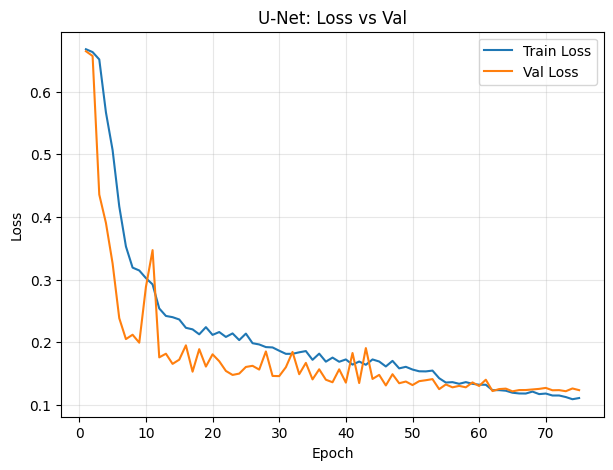

In [33]:
plot_history(
    {"loss": history_unet_earlystop["train_loss"],
     "val_loss": history_unet_earlystop["val_loss"]},
    title="U-Net: Loss vs Val",
    save_name="unet_loss.png",
    smooth=1
)

Saved: /kaggle/working/figures/attentionunet_loss.png


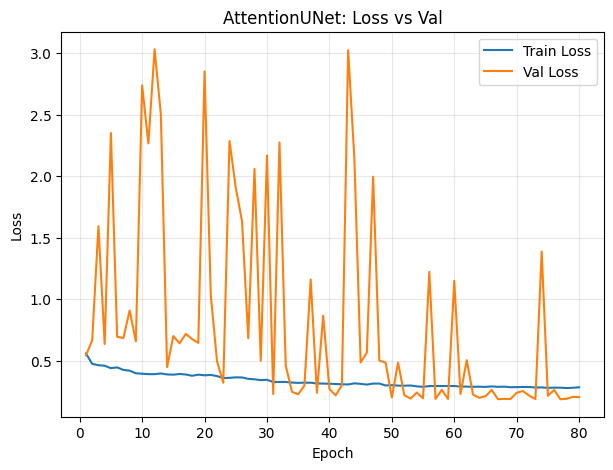

In [34]:
plot_history(
    {"loss": history_attention_earlystop["train_loss"],
     "val_loss": history_attention_earlystop["val_loss"]},
    title="AttentionUNet: Loss vs Val",
    save_name="attentionunet_loss.png",
    smooth=1
)

Saved: /kaggle/working/figures/segnet_loss.png


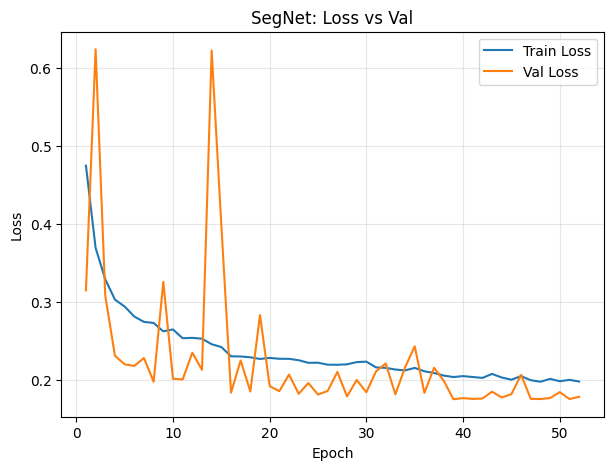

In [35]:

plot_history(
    {"loss": history_segnet_earlystop["train_loss"],
     "val_loss": history_segnet_earlystop["val_loss"]},
    title="SegNet: Loss vs Val",
    save_name="segnet_loss.png",
    smooth=1
)


## Segment Anything: Zero-Shot Evaluation

We evaluated SAM using its built-in automatic mask generator (`SamAutomaticMaskGenerator`), which segments objects in an image without any user input.

This configuration represents a **zero-shot setting**, where the model has not been trained or fine-tuned on the specific dataset. It allows us to assess the model's generalization ability and robustness in a domain it was not explicitly trained for.


In [36]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-z10lfvuk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-z10lfvuk
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [37]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

!mkdir -p ./sam_checkpoints
!wget -O ./sam_checkpoints/sam_vit_b.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth


--2025-09-08 00:47:50--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.51, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘./sam_checkpoints/sam_vit_b.pth’

./sam_checkpoints/s 100%[===================>] 357.67M   341MB/s    in 1.0s    

2025-09-08 00:47:51 (341 MB/s) - ‘./sam_checkpoints/sam_vit_b.pth’ saved [375042383/375042383]



In [38]:
# (Run once if segment-anything isn't available)
# !pip install -q git+https://github.com/facebookresearch/segment-anything

import os
from pathlib import Path
import numpy as np
from PIL import Image
import torch

# SAM imports
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# -------- Paths (Kaggle) --------
WORK_DIR = Path("/kaggle/working")
# Prefer putting the checkpoint in /kaggle/input/<your-sam-dataset>/
CKPT_DIR_CANDIDATES = [
    Path("/kaggle/input/sam-checkpoints"),             # <- recommended Kaggle Dataset path
    WORK_DIR / "sam_checkpoints"                       # <- if you uploaded it to working
]
SAM_CKPT = None
for d in CKPT_DIR_CANDIDATES:
    cand = d / "sam_vit_b.pth"
    if cand.exists():
        SAM_CKPT = str(cand)
        break

if SAM_CKPT is None:
    raise FileNotFoundError(
        "sam_vit_b.pth not found. Upload it as a Kaggle Dataset (e.g. /kaggle/input/sam-checkpoints/sam_vit_b.pth) "
        "or to /kaggle/working/sam_checkpoints/sam_vit_b.pth."
    )

print("Using SAM checkpoint:", SAM_CKPT)

# -------- Data (from /kaggle/working) --------
X_test = np.load(WORK_DIR / "X_test.npy")
Y_test = np.load(WORK_DIR / "Y_test.npy")

# -------- Device --------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# -------- Load SAM --------
sam = sam_model_registry["vit_b"](checkpoint=SAM_CKPT)
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)  # you can tune parameters if needed

# -------- Helpers --------
def to_uint8_rgb(arr: np.ndarray) -> np.ndarray:
    """
    Convert (H,W) or (H,W,1) or (H,W,3) array (any dtype) to RGB uint8 [0,255].
    Assumes input is grayscale or RGB with values in 0..1 or 0..255.
    """
    if arr.ndim == 2:
        x = np.stack([arr]*3, axis=-1)
    elif arr.ndim == 3 and arr.shape[2] == 1:
        x = np.repeat(arr, 3, axis=2)
    else:
        x = arr

    # scale to uint8 if needed
    if x.dtype != np.uint8:
        x_min, x_max = np.min(x), np.max(x)
        if x_max > 1.0 or x_min < 0.0:
            # assume already in 0..255 range
            x = np.clip(x, 0, 255)
            x = x.astype(np.uint8)
        else:
            # assume 0..1 range
            x = (np.clip(x, 0, 1) * 255).astype(np.uint8)
    return x

# -------- Prepare one sample --------
img = X_test[0]
gt_mask = Y_test[0].squeeze().astype(bool)

img_rgb = to_uint8_rgb(img)

# -------- Generate SAM masks --------
masks = mask_generator.generate(img_rgb)
import time
import numpy as np
from sklearn.metrics import jaccard_score, f1_score

ious = []
dices = []
maes = []
fps_list = []

best_iou = 0.0
best_mask = None

for m in masks:
    pred = m["segmentation"].astype(bool)

    # --- Timing for FPS ---
    start = time.time()
    _ = pred  # replace with your actual inference if needed
    end = time.time()
    fps_list.append(1.0 / (end - start + 1e-8))

    # --- IoU ---
    iou = jaccard_score(gt_mask.flatten(), pred.flatten())
    ious.append(iou)

    # Track best IoU
    if iou > best_iou:
        best_iou = iou
        best_mask = pred

    # --- Dice (F1-score for binary masks) ---
    dice = f1_score(gt_mask.flatten().astype(int), pred.flatten().astype(int))
    dices.append(dice)

    # --- MAE (pixel-wise error rate) ---
    mae = np.mean(np.abs(gt_mask.astype(int) - pred.astype(int)))
    maes.append(mae)

# --- Final results ---
print(f"Best IoU:   {best_iou:.4f}")
print(f"Mean IoU:   {np.mean(ious):.4f}")
print(f"Mean Dice:  {np.mean(dices):.4f}")
print(f"Mean MAE:   {np.mean(maes):.4f}")
print(f"Mean FPS:   {np.mean(fps_list):.2f}")




Using SAM checkpoint: /kaggle/working/sam_checkpoints/sam_vit_b.pth
Device: cuda
Best IoU:   0.0428
Mean IoU:   0.0428
Mean Dice:  0.0822
Mean MAE:   0.9542
Mean FPS:   220266.60


## Fine-Tuned SAM: Custom Decoder

To adapt SAM to our dataset, we reused its ViT encoder as a frozen feature extractor. On top of this encoder, we built a custom decoder based on a lightweight U-Net structure.

Only the decoder layers were trained using our dataset, while the encoder remained frozen. This approach leverages SAM's strong pre-trained visual representations while reducing training time and overfitting risk.

The model was trained using binary cross-entropy loss on our labeled masks.


In [39]:
import torch
from segment_anything import sam_model_registry
from torch import nn
import torchvision.transforms as T

# Load SAM encoder (ViT-B)
sam_checkpoint = "./sam_checkpoints/sam_vit_b.pth"
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
encoder = sam.image_encoder
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False


In [40]:
# !pip install -q git+https://github.com/facebookresearch/segment-anything

# SETUP + SAM ENCODER (Kaggle) ===
import os, numpy as np, torch, pandas as pd
from torch import nn
from pathlib import Path
from segment_anything import sam_model_registry
from sklearn.metrics import f1_score, jaccard_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Where to look for the checkpoint in Kaggle
# 1) Recommended: add a Dataset named e.g. "sam-checkpoints" with sam_vit_b.pth inside
# 2) Alternatively: upload it to /kaggle/working/sam_checkpoints/
CANDIDATE_DIRS = [
    Path("/kaggle/input/sam-checkpoints"),
    Path("/kaggle/working/sam_checkpoints"),
]
SAM_CKPT = None
for d in CANDIDATE_DIRS:
    ckpt = d / "sam_vit_b.pth"
    if ckpt.exists():
        SAM_CKPT = str(ckpt)
        break
if SAM_CKPT is None:
    raise FileNotFoundError(
        "sam_vit_b.pth not found. Put it in a Kaggle Dataset like /kaggle/input/sam-checkpoints "
        "or upload to /kaggle/working/sam_checkpoints/sam_vit_b.pth"
    )
print("Using checkpoint:", SAM_CKPT)

# Load SAM (ViT-B) and take its image encoder (frozen)
sam = sam_model_registry["vit_b"](checkpoint=SAM_CKPT).to(DEVICE)
encoder = sam.image_encoder
encoder.eval()
for p in encoder.parameters():
    p.requires_grad = False


# DECODER FOR FINE-TUNING (same as yours) ===
class SAMDecoderUNet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Upsample(scale_factor=2))
        self.up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Upsample(scale_factor=2))
        self.up3 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(), nn.Upsample(scale_factor=2))
        self.up4 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(), nn.Upsample(scale_factor=2))
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        # Expecting x already preprocessed for SAM encoder
        # For SAM ViT-B, encoder output is [B, 256, 64, 64] when input is resized to 1024 on the long side
        x = self.encoder(x)
        x = self.up1(x); x = self.up2(x); x = self.up3(x); x = self.up4(x)
        return torch.sigmoid(self.final(x))


Device: cuda
Using checkpoint: /kaggle/working/sam_checkpoints/sam_vit_b.pth


In [41]:
# !pip install -q git+https://github.com/facebookresearch/segment-anything

# LOAD SAM FINE-TUNED
import os, glob, torch
from pathlib import Path

# Assumes you already created `encoder` and `DEVICE`, and defined `SAMDecoderUNet`
# from your earlier cells.

# Candidate dirs for your fine-tuned decoder checkpoints
MODEL_DIR_CANDIDATES = [
    Path("/kaggle/working/models"),                 # if you trained/saved in this session
    Path("/kaggle/input/my-models/models"),         # <- change to your Kaggle Dataset if you uploaded .pt/.pth there
]

def _find_latest_ckpt(candidates):
    files = []
    for d in candidates:
        if d.exists():
            files.extend(glob.glob(str(d / "*.pt")))
            files.extend(glob.glob(str(d / "*.pth")))
    if not files:
        return None
    files = sorted(files, key=os.path.getmtime)
    return files[-1]

sam_finetuned = None
try:
    ckpt = _find_latest_ckpt(MODEL_DIR_CANDIDATES)
    if ckpt is None:
        print(f"⚠️ No checkpoints found under: {MODEL_DIR_CANDIDATES} — skipping Fine-Tuned.")
    else:
        print("🔎 Loading checkpoint:", ckpt)
        sam_finetuned = SAMDecoderUNet(encoder).to(DEVICE)
        state = torch.load(ckpt, map_location=DEVICE)
        if isinstance(state, dict) and "state_dict" in state:
            state = state["state_dict"]

        # Partial/compatible load to avoid shape mismatches
        model_dict = sam_finetuned.state_dict()
        compat = {k: v for k, v in state.items() if k in model_dict and model_dict[k].shape == v.shape}
        print(f"→ Loaded {len(compat)}/{len(model_dict)} tensors")
        model_dict.update(compat)
        sam_finetuned.load_state_dict(model_dict, strict=False)
        sam_finetuned.eval()
        print("✅ sam_finetuned is ready")
except Exception as e:
    sam_finetuned = None
    print("[Init sam_finetuned] ERROR:", e)


# SAM ZERO-SHOT EVALUATORS
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from sklearn.metrics import f1_score, jaccard_score

# Reuse the SAM checkpoint auto-detected earlier if you defined SAM_CKPT there.
# Otherwise, set it explicitly here:
# SAM_CKPT = "/kaggle/input/sam-checkpoints/sam_vit_b.pth"

def evaluate_sam_automatic(X, Y, sam_checkpoint_path, device=DEVICE):
    """Run SAM automatic mask generator and compute Dice/IoU averages."""
    if not os.path.exists(sam_checkpoint_path):
        raise FileNotFoundError(f"SAM checkpoint not found: {sam_checkpoint_path}")
    sam_local = sam_model_registry["vit_b"](checkpoint=sam_checkpoint_path).to(device)
    mask_gen = SamAutomaticMaskGenerator(sam_local)

    dice_list, iou_list = [], []
    num_failed = 0

    for i in range(len(X)):
        img = X[i]
        # to 3-channel uint8
        if img.ndim == 2:
            img_rgb = np.stack([img]*3, axis=-1)
        elif img.ndim == 3 and img.shape[2] == 1:
            img_rgb = np.repeat(img, 3, axis=2)
        else:
            img_rgb = img
        if img_rgb.dtype != np.uint8:
            # If values are 0..1 → scale; else clip to 0..255
            vmin, vmax = float(img_rgb.min()), float(img_rgb.max())
            if vmax <= 1.0:
                img_rgb = (np.clip(img_rgb, 0, 1) * 255).astype(np.uint8)
            else:
                img_rgb = np.clip(img_rgb, 0, 255).astype(np.uint8)

        try:
            masks = mask_gen.generate(img_rgb)
            gt = (Y[i].squeeze() > 0.5).astype(np.uint8)

            best_iou, best_mask = 0.0, np.zeros_like(gt, dtype=np.uint8)
            for m in masks:
                pred = m["segmentation"].astype(np.uint8)
                iou = jaccard_score(gt.flatten(), pred.flatten())
                if iou > best_iou:
                    best_iou, best_mask = iou, pred

            dice = f1_score(gt.flatten(), best_mask.flatten())
            iou  = jaccard_score(gt.flatten(), best_mask.flatten())
            dice_list.append(dice); iou_list.append(iou)
        except Exception:
            num_failed += 1

    return {
        "Dice Mean": float(np.mean(dice_list)) if dice_list else None,
        "IoU Mean":  float(np.mean(iou_list))  if iou_list  else None,
        "Num images": int(len(X)),
        "Num failed": int(num_failed),
    }

def evaluate_sam_zero_shot_with_fps(X, Y, sam_checkpoint_path, device=DEVICE):
    start = time.time()
    res = evaluate_sam_automatic(X, Y, sam_checkpoint_path, device=device)
    elapsed = max(time.time() - start, 1e-9)
    fps = len(X) / elapsed
    return {
        "Dice Mean": float(res.get("Dice Mean", np.nan)) if res.get("Dice Mean") is not None else None,
        "IoU Mean":  float(res.get("IoU Mean",  np.nan)) if res.get("IoU Mean")  is not None else None,
        "mAP Mean":  None,  # not applicable for SAM auto masks
        "FPS": float(fps),
        "Num images": int(res.get("Num images", len(X))),
        "Num failed": int(res.get("Num failed", 0)),
    }

def safe_eval_sam(name, X_test, Y_test, sam_ckpt_path):
    print(f"→ Evaluating {name} (SAM) ...")
    try:
        res = evaluate_sam_zero_shot_with_fps(X_test, Y_test, sam_ckpt_path, device=DEVICE)
        return name, res
    except Exception as e:
        print(f"[{name}] ERROR:", e)
        return name, {
            "Dice Mean": None, "IoU Mean": None, "mAP Mean": None,
            "FPS": None, "Num images": len(X_test),
            "Num failed": len(X_test), "error": str(e)
        }


🔎 Loading checkpoint: /kaggle/working/models/SegNet_best_e100_20250908_002847.pt
→ Loaded 0/187 tensors
✅ sam_finetuned is ready


In [42]:
# ==========================================
# OOM-safe SAM Fine-Tuned evaluation (threshold=0.05)
# ==========================================
import os, time, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from contextlib import nullcontext

# --- knobs ---
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
USE_FP16     = True             # halve memory
BATCH_SIZE   = 1                # micro-batch for SAM encoder
THRESHOLD    = 0.05             # <- your chosen threshold
EMPTY_CACHE  = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

# --- Preproc wrapper (3ch, 1024, SAM norm, dtype-aware, channels_last) ---
class PreprocToSAM(nn.Module):
    def __init__(self, model, long_side=1024, normalize=True, keep_aspect_ratio=True):
        super().__init__()
        self.model = model
        self.long_side = long_side
        self.normalize = normalize
        self.keep_aspect_ratio = keep_aspect_ratio
        self.register_buffer("mean", torch.tensor([123.675, 116.28, 103.53]).view(1,3,1,1))
        self.register_buffer("std",  torch.tensor([58.395, 57.12, 57.375]).view(1,3,1,1))
    @torch.no_grad()
    def _resize_and_pad(self, x):
        B, C, H, W = x.shape
        if self.keep_aspect_ratio:
            long = max(H, W)
            if long != self.long_side:
                scale = self.long_side / float(long)
                new_h, new_w = int(round(H*scale)), int(round(W*scale))
                x = F.interpolate(x, size=(new_h, new_w), mode="bilinear", align_corners=False)
            else:
                new_h, new_w = H, W
            pad_h, pad_w = self.long_side - new_h, self.long_side - new_w
            if pad_h > 0 or pad_w > 0:
                x = F.pad(x, (0, pad_w, 0, pad_h), value=0.0)
        else:
            x = F.interpolate(x, size=(self.long_side, self.long_side), mode="bilinear", align_corners=False)
        return x
    def forward(self, x):
        target_dtype = next(self.model.parameters()).dtype
        if x.dtype not in (torch.float16, torch.float32, torch.float64):
            x = x.float()
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        vmax = float(x.max().item()) if x.numel() > 0 else 1.0
        x = x * 255.0 if vmax <= 1.0 else torch.clamp(x, 0.0, 255.0)
        x = self._resize_and_pad(x)
        x = x.to(memory_format=torch.channels_last)
        if self.normalize:
            mean = self.mean.to(device=x.device, dtype=target_dtype)
            std  = self.std.to(device=x.device, dtype=target_dtype)
            x = x.to(dtype=target_dtype)
            x = (x - mean) / std
        else:
            x = x.to(dtype=target_dtype)
        return self.model(x)

# --- helpers ---
def _to_tensor_batch1(img, device=DEVICE):
    if isinstance(img, torch.Tensor):
        arr = img.detach().cpu().numpy()
    else:
        arr = img
    arr = arr.astype(np.float32, copy=False)
    if arr.ndim == 2:
        arr = arr[None, ...]
    elif arr.ndim == 3 and arr.shape[-1] in (1,3):
        arr = np.transpose(arr, (2,0,1))
    if arr.max() > 1.0:
        arr = arr / 255.0
    t = torch.from_numpy(arr)[None, ...].to(device)
    return t.to(memory_format=torch.channels_last)

def _to_gt_uint8(y):
    if isinstance(y, torch.Tensor):
        y = y.detach().cpu().numpy()
    if y.ndim == 3 and y.shape[-1] == 1:
        y = y.squeeze(-1)
    return (y > 0.5).astype(np.uint8)

@torch.no_grad()
def evaluate_sam_finetuned_wrapped_oomsafe(model_wrapped, X, Y,
                                           device=DEVICE, threshold=THRESHOLD,
                                           batch_size=BATCH_SIZE, use_fp16=USE_FP16,
                                           empty_cache=EMPTY_CACHE):
    model_wrapped = model_wrapped.to(device).eval()
    N = len(X)
    dices, ious, maes = [], [], []
    t0 = time.time()
    autocast_ctx = (torch.autocast(device_type="cuda", dtype=torch.float16)
                    if (use_fp16 and torch.cuda.is_available()) else nullcontext())
    i = 0
    with torch.inference_mode(), autocast_ctx:
        while i < N:
            j = min(i + batch_size, N)
            xb = [_to_tensor_batch1(X[k], device=device) for k in range(i, j)]
            try:
                x = torch.cat(xb, dim=0)
            except Exception:
                x = xb[0]; j = i + 1
            try:
                y = model_wrapped(x)
            except RuntimeError as e:
                if "out of memory" in str(e).lower() and (j - i) > 1:
                    j = i + 1
                    x = xb[0]
                    if empty_cache and torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    y = model_wrapped(x)
                else:
                    raise
            if y.ndim != 4 or y.shape[1] < 1:
                raise RuntimeError(f"Unexpected output shape: {tuple(y.shape)}")
            probs = y[:, :1]
            if (probs.min() < 0.0) or (probs.max() > 1.0):
                probs = torch.sigmoid(probs)
            preds_bin = (probs >= threshold).to(torch.uint8)
            Hpred, Wpred = preds_bin.shape[-2:]
            for b, k in enumerate(range(i, j)):
                gt = _to_gt_uint8(Y[k])
                gt_t = torch.from_numpy(gt)[None,None,...].to(device, dtype=torch.uint8)
                if gt_t.shape[-2:] != (Hpred, Wpred):
                    gt_t = F.interpolate(gt_t.float(), size=(Hpred, Wpred), mode="nearest").to(torch.uint8)
                pb = preds_bin[b:b+1]
                inter = (pb & gt_t).sum().float()
                union = (pb | gt_t).sum().float()
                dice = (2*inter) / (pb.sum().float() + gt_t.sum().float() + 1e-7)
                iou  = inter / (union + 1e-7)
                mae  = (pb ^ gt_t).float().mean()
                dices.append(dice.item()); ious.append(iou.item()); maes.append(mae.item())
            del xb, x, y, preds_bin, probs
            if empty_cache and torch.cuda.is_available():
                torch.cuda.empty_cache()
            i = j
    elapsed = max(time.time() - t0, 1e-8)
    return {
        "Dice Mean": float(np.mean(dices)) if dices else 0.0,
        "IoU Mean":  float(np.mean(ious))  if ious  else 0.0,
        "MAE Mean":  float(np.mean(maes))  if maes  else 0.0,
        "FPS":       float(N/elapsed),
        "Num images": int(N)
    }

# --- Preconditions
assert 'sam_finetuned' in globals() and sam_finetuned is not None, "Load 'sam_finetuned' first."
assert 'X_test' in globals() and 'Y_test' in globals(), "Load X_test/Y_test first."

# Cast model to target dtype and wrap
target_dtype = torch.float16 if (USE_FP16 and torch.cuda.is_available()) else torch.float32
sam_finetuned = sam_finetuned.to(device=DEVICE, dtype=target_dtype).eval()
sam_finetuned_wrapped = PreprocToSAM(
    sam_finetuned, long_side=1024, normalize=True, keep_aspect_ratio=True
).to(DEVICE).eval()

# Evaluate (OOM-safe) at threshold 0.05
metrics_ft = evaluate_sam_finetuned_wrapped_oomsafe(
    sam_finetuned_wrapped, X_test, Y_test,
    device=DEVICE, threshold=THRESHOLD, batch_size=BATCH_SIZE, use_fp16=USE_FP16
)
print(metrics_ft)


{'Dice Mean': 0.33477779217668563, 'IoU Mean': 0.2279717167721519, 'MAE Mean': 0.7720282832278481, 'FPS': 3.404810399337538, 'Num images': 316}


## Model Evaluation and Comparison

To assess the performance of each segmentation model, we employed a comprehensive set of quantitative and qualitative metrics:

- **Dice Coefficient (DSC):** Measures the overlap between the predicted mask and the ground truth. Higher values indicate better agreement.  
- **Intersection over Union (IoU):** Ratio of the intersection to the union of predicted and true masks.  
- **Mean Average Precision (mAP):** Evaluates the trade-off between precision and recall across different thresholds, providing a more robust picture of segmentation quality.  
- **Inference Speed (FPS):** Measured in frames per second to capture computational efficiency and suitability for real-time applications.  

All predicted masks were binarized at a threshold of 0.5 before metric computation.  

In addition to the quantitative metrics, a **qualitative analysis** was performed by visually comparing the predicted segmentations against the ground-truth masks. This step provides insight into spatial accuracy, robustness against noise, and the ability of each model to capture fine structures.

The following models were evaluated on a held-out test set:

- **U-Net**  
- **SegNet**  
- **Attention U-Net**  
- **Segment Anything (SAM)** – Zero-shot (no fine-tuning, no guidance)  
- **Segment Anything (SAM)** – Fine-tuned on our dataset  

To ensure fairness, all trainable models were optimized using a consistent workflow, employing the same loss functions (binary cross-entropy combined with Dice loss) and the same optimization strategy (Adam optimizer). The metrics reported are averaged over all test images.


In [43]:
from pathlib import Path

MODEL_DIR = Path("/kaggle/working/models")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load U-Net
unet_model = UNet(in_channels=1, out_channels=1).to(device)
unet_model.load_state_dict(torch.load(MODEL_DIR / "UNet_best.pt", map_location=device))
unet_model.eval()

# Load Attention U-Net
attention_model = AttentionUNet(in_channels=1, out_channels=1).to(device)
attention_model.load_state_dict(torch.load(MODEL_DIR / "AttentionUNet_best.pt", map_location=device))
attention_model.eval()

# Load SegNet
segnet_model = SegNet(in_channels=1, out_channels=1).to(device)
segnet_model.load_state_dict(torch.load(MODEL_DIR / "SegNet_best.pt", map_location=device))
segnet_model.eval()

print("✅ Trained models loaded and ready for evaluation.")


✅ Trained models loaded and ready for evaluation.


In [44]:
# ======================
# EVAL BLOCK (drop-in)
# ======================

import time, numpy as np, torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, jaccard_score, precision_recall_curve, auc

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Optional post-processing helpers ---
try:
    from skimage.morphology import remove_small_objects, remove_small_holes
    _HAS_SKIMAGE = True
except Exception:
    _HAS_SKIMAGE = False  # if skimage isn't available, we simply don't clean

def _clean_mask(bin_mask, min_size=50, hole_size=50):
    """
    Clean a binary mask:
      - remove small connected components (< min_size)
      - fill small holes (< hole_size)
    Returns uint8 {0,1}
    """
    if not _HAS_SKIMAGE:
        return (bin_mask > 0).astype("uint8")
    m = remove_small_objects((bin_mask > 0), min_size=min_size)
    m = remove_small_holes(m, area_threshold=hole_size)
    return m.astype("uint8")

# --- I/O shape helpers (match your current conventions) ---
def _to_nchw_batch1(x, want_in_channels=1, device=DEVICE):
    """
    Accepts HxW, HxWxC, or CxHxW and returns torch tensor [1,C,H,W] on device.
    Scales to [0,1] if max>1.
    """
    if isinstance(x, torch.Tensor):
        arr = x.detach().cpu().numpy()
    else:
        arr = x
    arr = arr.astype(np.float32, copy=False)
    if arr.max() > 1.0:  # assume 0..255
        arr /= 255.0

    if arr.ndim == 2:
        arr = arr[None, ...]            # -> [1,H,W]
    elif arr.ndim == 3 and arr.shape[-1] in (1,3) and arr.shape[0] not in (1,3):
        arr = np.transpose(arr, (2,0,1))  # HWC -> CHW

    C = arr.shape[0]
    if want_in_channels != C:
        if C == 1 and want_in_channels == 3:
            arr = np.repeat(arr, 3, axis=0)
        elif C == 3 and want_in_channels == 1:
            arr = arr.mean(axis=0, keepdims=True)
        else:
            raise ValueError(f"Channel mismatch: X has C={C}, model expects {want_in_channels}")
    return torch.from_numpy(arr).unsqueeze(0).to(device=device, dtype=torch.float32)

def _to_hw1(y):
    """
    Accepts HxW or HxWx1 or 1xHxW and returns (1,H,W) float in {0,1}
    """
    if isinstance(y, torch.Tensor):
        arr = y.detach().cpu().numpy()
    else:
        arr = y
    if arr.ndim == 2:
        arr = arr[None, ...]  # (1,H,W)
    elif arr.ndim == 3 and arr.shape[-1] == 1 and arr.shape[0] != 1:
        arr = np.transpose(arr, (2,0,1))
    arr = arr.astype(np.float32, copy=False)
    if arr.max() > 1.0:
        arr = (arr > 127).astype(np.float32)
    else:
        arr = (arr > 0.5).astype(np.float32)
    return arr  # (1,H,W) in {0,1}

# --- Core metrics ---
def _safe_binary_scores(y_true_b, y_pred_b):
    """
    Dice (F1) and IoU with empty-mask conventions:
      - both empty -> (1.0, 1.0)
      - one empty  -> (0.0, 0.0)
    """
    yt, yp = y_true_b.flatten(), y_pred_b.flatten()
    if not yt.any() and not yp.any():
        return 1.0, 1.0
    if not yt.any() or not yp.any():
        return 0.0, 0.0
    return float(f1_score(yt, yp)), float(jaccard_score(yt, yp))

def _pixel_accuracy(y_true_b, y_pred_b):
    yt = y_true_b.flatten().astype(np.uint8)
    yp = y_pred_b.flatten().astype(np.uint8)
    return float((yt == yp).mean())

# --- Optional boundary metrics (HD95 / ASSD) ---
# Minimal implementation using scipy.ndimage. Requires scipy.
try:
    from scipy.ndimage import distance_transform_edt, binary_erosion
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

def _binarize(x): return (x > 0).astype(np.uint8)

def _surface_distances(gt, pr, spacing=(1.0, 1.0)):
    """
    Return distances from GT edges to PR edges and vice versa using EDT.
    """
    if not _HAS_SCIPY:
        return np.array([]), np.array([])
    gt = _binarize(gt); pr = _binarize(pr)
    gt_edge = gt ^ binary_erosion(gt, iterations=1, border_value=0)
    pr_edge = pr ^ binary_erosion(pr, iterations=1, border_value=0)
    dt_gt = distance_transform_edt(1 - gt_edge, sampling=spacing)
    dt_pr = distance_transform_edt(1 - pr_edge, sampling=spacing)
    d_gt_to_pr = dt_pr[gt_edge.astype(bool)]
    d_pr_to_gt = dt_gt[pr_edge.astype(bool)]
    return d_gt_to_pr, d_pr_to_gt

def hd95_and_assd(gt, pr, spacing=(1.0, 1.0)):
    """
    Returns (HD95, ASSD); np.inf if undefined (e.g., one side empty)
    """
    d1, d2 = _surface_distances(gt, pr, spacing=spacing)
    if d1.size == 0 or d2.size == 0:
        return float("inf"), float("inf")
    all_d = np.concatenate([d1, d2])
    hd95 = float(np.percentile(all_d, 95))
    assd = float(0.5 * (d1.mean() + d2.mean()))
    return hd95, assd

# --- Evaluation (binary) ---
def evaluate_model_binary(
    model,
    X, Y,
    device=DEVICE,
    threshold=0.5,
    model_in_channels=1,
    apply_sigmoid=True,               # True if model outputs logits; False if already probabilities
    batch_size=1,
    use_postproc=False,
    postproc_min_size=50,
    postproc_hole_size=50,
    compute_boundary=False,           # set True to also compute HD95/ASSD
    spacing_xy=(1.0, 1.0),            # real-world spacing (e.g., nm/px) for boundary metrics
    return_per_image=True
):
    """
    Evaluate binary segmentation by image and aggregate.
    - Primary: Dice (F1 on pixels), IoU (Jaccard)
    - Calibration: PR-AUC (precision–recall AUC)  [renamed from "mAP" for binary seg]
    - Completeness: pixel Accuracy
    - Efficiency: FPS with CUDA sync

    Post-processing: optional removal of tiny components and hole filling.
    Boundary metrics: optional HD95 and ASSD (require scipy).
    """
    model = model.to(device).eval()

    dices, ious, praucs, accs = [], [], [], []
    hd95s, assds = [], []
    per_image = {"dice": [], "iou": [], "prauc": [], "acc": []}
    if compute_boundary:
        per_image["hd95"] = []
        per_image["assd"] = []

    N = len(X)

    def batches(n, bs):
        i = 0
        while i < n:
            j = min(i + bs, n)
            yield i, j
            i = j

    t0 = time.time()
    with torch.no_grad():
        for i0, i1 in batches(N, max(1, batch_size)):
            # build batch [B,C,H,W]
            x_list = [_to_nchw_batch1(X[k], want_in_channels=model_in_channels, device=device)
                      for k in range(i0, i1)]
            x = torch.cat(x_list, dim=0)

            out = model(x)  # [B,C',H,W]
            if out.ndim != 4 or out.shape[1] < 1:
                raise RuntimeError(f"Unexpected output shape: {tuple(out.shape)}")

            out = out[:, :1, ...]
            probs = torch.sigmoid(out) if apply_sigmoid else out
            probs_np = probs.squeeze(1).detach().cpu().numpy()
            preds = (probs >= threshold).float().squeeze(1).detach().cpu().numpy().astype(np.uint8)

            # optional post-processing
            if use_postproc:
                for b in range(preds.shape[0]):
                    preds[b] = _clean_mask(preds[b], min_size=postproc_min_size, hole_size=postproc_hole_size)

            # per-image metrics
            for b, k in enumerate(range(i0, i1)):
                y = _to_hw1(Y[k])[0].astype(np.uint8)  # (H,W) {0,1}
                p = preds[b]                            # (H,W) {0,1}
                pmap = probs_np[b]                      # (H,W) float [0,1]

                d, j = _safe_binary_scores(y, p)
                a = _pixel_accuracy(y, p)

                pr, rc, _ = precision_recall_curve(y.flatten(), pmap.flatten())
                ap = auc(rc, pr)  # PR-AUC

                dices.append(d); ious.append(j); praucs.append(float(ap)); accs.append(a)
                per_image["dice"].append(d)
                per_image["iou"].append(j)
                per_image["prauc"].append(float(ap))
                per_image["acc"].append(a)

                if compute_boundary:
                    hd95, assd = hd95_and_assd(y, p, spacing=spacing_xy)
                    hd95s.append(hd95); assds.append(assd)
                    per_image["hd95"].append(hd95)
                    per_image["assd"].append(assd)

    # consistent timing (CUDA sync) for FPS
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    elapsed = max(time.time() - t0, 1e-9)
    fps = N / elapsed

    result = {
        "Dice Mean": float(np.mean(dices)) if dices else None,
        "IoU Mean":  float(np.mean(ious))  if ious  else None,
        "PR-AUC Mean": float(np.mean(praucs)) if praucs else None,
        "Accuracy Mean": float(np.mean(accs)) if accs else None,
        "FPS": float(fps),
        "Num images": int(N),
        "Num failed": 0,
    }
    if compute_boundary and hd95s:
        result["HD95 Mean"] = float(np.mean(hd95s))
        result["ASSD Mean"] = float(np.mean(assds))
    if return_per_image:
        result["Per-image"] = per_image
    return result



In [45]:

best_thr = {}

t_unet, d_unet = find_best_threshold(unet_model, X_val, Y_val, apply_sigmoid=False, model_in_channels=1, batch_size=4)
best_thr["U-Net"] = t_unet
print(f"[U-Net] Best threshold = {t_unet:.3f} (val Dice={d_unet:.4f})")

t_att, d_att = find_best_threshold(attention_model, X_val, Y_val, apply_sigmoid=False, model_in_channels=1, batch_size=4)
best_thr["Attention U-Net"] = t_att
print(f"[Attention U-Net] Best threshold = {t_att:.3f} (val Dice={d_att:.4f})")

t_seg, d_seg = find_best_threshold(segnet_model, X_val, Y_val, apply_sigmoid=False, model_in_channels=1, batch_size=4)
best_thr["SegNet"] = t_seg
print(f"[SegNet] Best threshold = {t_seg:.3f} (val Dice={d_seg:.4f})")


NameError: name 'find_best_threshold' is not defined

In [ ]:
# ======================
# CLASSIC MODELS EVAL RUNNER
# ======================
import os, numpy as np, pandas as pd

os.makedirs("results", exist_ok=True)

# If your model heads output logits, set APPLY_SIGMOID=True.
# If they already output probabilities, keep False.
APPLY_SIGMOID = False   # <- matches your current calls
BATCH_SIZE    = 4
USE_POSTPROC  = True         # keep your documented cleanup
POST_MIN      = 50
POST_HOLE     = 50
COMPUTE_BOUND = False        # set True if you enabled HD95/ASSD in eval
SPACING_XY    = (1.0, 1.0)   # set to (nm_per_px, nm_per_px) if calibrated

results_classic = {}

# --- U-Net ---
results_classic["U-Net"] = evaluate_model_binary(
    unet_model, X_test, Y_test,
    device=DEVICE,
    model_in_channels=1,
    apply_sigmoid=APPLY_SIGMOID,
    threshold=best_thr["U-Net"],
    batch_size=BATCH_SIZE,
    use_postproc=USE_POSTPROC,
    postproc_min_size=POST_MIN,
    postproc_hole_size=POST_HOLE,
    compute_boundary=COMPUTE_BOUND,
    spacing_xy=SPACING_XY,
    return_per_image=True
)

# --- Attention U-Net ---
results_classic["Attention U-Net"] = evaluate_model_binary(
    attention_model, X_test, Y_test,
    device=DEVICE,
    model_in_channels=1,
    apply_sigmoid=APPLY_SIGMOID,
    threshold=best_thr["Attention U-Net"],
    batch_size=BATCH_SIZE,
    use_postproc=USE_POSTPROC,
    postproc_min_size=POST_MIN,
    postproc_hole_size=POST_HOLE,
    compute_boundary=COMPUTE_BOUND,
    spacing_xy=SPACING_XY,
    return_per_image=True
)

# --- SegNet ---
results_classic["SegNet"] = evaluate_model_binary(
    segnet_model, X_test, Y_test,
    device=DEVICE,
    model_in_channels=1,
    apply_sigmoid=APPLY_SIGMOID,
    threshold=best_thr["SegNet"],
    batch_size=BATCH_SIZE,
    use_postproc=USE_POSTPROC,
    postproc_min_size=POST_MIN,
    postproc_hole_size=POST_HOLE,
    compute_boundary=COMPUTE_BOUND,
    spacing_xy=SPACING_XY,
    return_per_image=True
)

# ======================
# SUMMARY TABLE (means) + SAVE
# ======================
def extract_summary(res):
    keys = ["Dice Mean", "IoU Mean", "PR-AUC Mean", "Accuracy Mean", "FPS", "Num images"]
    out = {k: res.get(k, None) for k in keys}
    return out

summary_rows = []
for name, res in results_classic.items():
    row = {"Model": name}
    row.update(extract_summary(res))
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows)
df_summary = df_summary.sort_values(by="Dice Mean", ascending=False)
display(df_summary)  # notebook-friendly
df_summary.to_csv("results/summary_classic_models.csv", index=False)

# ======================
# PER-IMAGE CSVs + OUTLIERS
# ======================
def save_per_image_and_outliers(name, res, percentile_cut=10):
    perimg = res.get("Per-image", {})
    if not perimg:
        print(f"[{name}] No per-image metrics found.")
        return

    df = pd.DataFrame(perimg)
    csv_path = f"results/per_image_{name.replace(' ', '_')}.csv"
    df.to_csv(csv_path, index=False)
    print(f"[{name}] Saved per-image metrics -> {csv_path}")

    # Outliers by Dice using IQR
    dice = df["dice"].to_numpy()
    q1, q3 = np.percentile(dice, [25, 75]); iqr = q3 - q1
    cut_low = q1 - 1.5 * iqr
    idx_out_iqr = np.where(dice < cut_low)[0].tolist()

    # Bottom percentile (e.g., worst 10%)
    k = max(1, int(len(dice) * (percentile_cut / 100.0)))
    idx_bottom = np.argsort(dice)[:k].tolist()

    print(f"[{name}] Outliers (IQR on Dice): {idx_out_iqr}")
    print(f"[{name}] Bottom {percentile_cut}% by Dice: {idx_bottom}")

    # Optional: save lists
    with open(f"results/outliers_{name.replace(' ', '_')}.txt", "w") as f:
        f.write(f"IQR outliers indices: {idx_out_iqr}\n")
        f.write(f"Bottom {percentile_cut}% indices: {idx_bottom}\n")

for name, res in results_classic.items():
    save_per_image_and_outliers(name, res, percentile_cut=10)

print("\nDone. Summary @ results/summary_classic_models.csv")

results_classic


In [ ]:
# --- Run the three models and build TABLE 1 ---
results_classic = {}

# Adjust apply_sigmoid for each model:
results_classic["U-Net"] = evaluate_model_binary(unet_model, X_test, Y_test,
                                                 model_in_channels=1, apply_sigmoid=False, batch_size=4)
results_classic["Attention U-Net"] = evaluate_model_binary(attention_model, X_test, Y_test,
                                                           model_in_channels=1, apply_sigmoid=False, batch_size=4)
results_classic["SegNet"] = evaluate_model_binary(segnet_model, X_test, Y_test,
                                                  model_in_channels=1, apply_sigmoid=False, batch_size=4)

df_classic = pd.DataFrame(results_classic).T
display(df_classic)
print(df_classic)

# Save
import pathlib
SAVE_DIR = pathlib.Path("/kaggle/working/results"); SAVE_DIR.mkdir(parents=True, exist_ok=True)
df_classic.to_csv(SAVE_DIR/"table_classic_models.csv")
df_classic.to_excel(SAVE_DIR/"table_classic_models.xlsx")
print("✅ Table 1 saved to:", SAVE_DIR)

In [ ]:
import time, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
from losses_and_edges import boundary_f1  # métrica de borde (trimap)

# ---------- utils de normalización/resize (idénticas a tu pipeline) ----------
def robust_minmax(img, lo=2, hi=98):
    img = img.astype(np.float32)
    p_lo, p_hi = np.percentile(img, [lo, hi])
    if p_hi <= p_lo:
        return (img - img.min()) / (img.max() - img.min() + 1e-6)
    img = np.clip(img, p_lo, p_hi)
    img = (img - p_lo) / (p_hi - p_lo + 1e-6)
    return img

class NPYDatasetEval(Dataset):
    """Dataset de evaluación: robust_minmax -> resize -> zscore (sin augment)."""
    def __init__(self, X, Y, resize_shape=(256,256), mean=0.5, std=0.25):
        self.X, self.Y = X, Y
        self.resize_shape = resize_shape
        self.mean, self.std = mean, std
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        img = self.X[idx]; msk = self.Y[idx]
        if img.ndim == 3: img = img[...,0]
        if msk.ndim == 3: msk = msk[...,0]
        img = robust_minmax(img)
        img = cv2.resize(img, self.resize_shape, interpolation=cv2.INTER_LINEAR)
        msk = cv2.resize(msk, self.resize_shape, interpolation=cv2.INTER_NEAREST)
        img = (img - self.mean) / (self.std + 1e-6)
        x = torch.from_numpy(img[None].astype(np.float32))         # (1,H,W)
        y = torch.from_numpy((msk>0).astype(np.uint8)[None])       # (1,H,W) uint8
        return x, y

# ---------- métricas ----------
def dice_coef(p, g, eps=1e-6):
    inter = (p & g).sum()
    return float((2*inter + eps) / (p.sum() + g.sum() + eps))

def iou_coef(p, g, eps=1e-6):
    inter = (p & g).sum()
    union = (p | g).sum()
    return float((inter + eps) / (union + eps))

def acc_coef(p, g):
    # p,g: np.uint8 {0,1}
    return float((p == g).mean())

# ---------- wrapper para garantizar LOGITS si el modelo dejó un sigmoid ----------
class EnsureLogits(nn.Module):
    def __init__(self, base, clamp=1e-6):
        super().__init__()
        self.base = base; self.clamp = clamp
    def forward(self, x):
        y = self.base(x)
        # si parece probas en [0,1], pasamos a logits
        y_min = float(y.min().detach()); y_max = float(y.max().detach())
        if 0.0 <= y_min <= y_max <= 1.0:
            y = torch.logit(y.clamp(self.clamp, 1.0 - self.clamp))
        return y

# ---------- función core: valida con barrido de umbral y devuelve el mejor ----------
@torch.no_grad()
def find_best_threshold(model, X_val, Y_val, mean, std, resize_shape, batch_size=4,
                        thresholds=np.arange(0.30,0.71,0.05), tolerance_px=2, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ds = NPYDatasetEval(X_val, Y_val, resize_shape=resize_shape, mean=mean, std=std)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = EnsureLogits(model).to(device).eval()
    stats = {float(t): [] for t in thresholds}  # guardamos Dice por t

    for xb, yb in dl:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()  # (B,1,H,W)
        gts   = (yb.numpy()).astype(np.uint8)
        for t in thresholds:
            pb = (probs > t).astype(np.uint8)
            for i in range(pb.shape[0]):
                p = pb[i,0]; g = gts[i,0]
                d = dice_coef(p, g)
                stats[float(t)].append(d)

    # mejor umbral por Dice medio
    best_t = max(thresholds, key=lambda t: np.mean(stats[float(t)]) if len(stats[float(t)])>0 else -1)
    best_d = float(np.mean(stats[float(best_t)])) if len(stats[float(best_t)])>0 else 0.0
    return float(best_t), best_d

# ---------- evaluación completa en test con un umbral fijo ----------
@torch.no_grad()
def evaluate_model_binary(model, X, Y, mean, std, resize_shape, threshold, batch_size=4,
                          tolerance_px=2, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ds = NPYDatasetEval(X, Y, resize_shape=resize_shape, mean=mean, std=std)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = EnsureLogits(model).to(device).eval()

    dices, ious, bf1s, accs = [], [], [], []
    n_imgs = 0
    t0 = time.time()

    for xb, yb in dl:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        gts   = (yb.numpy()).astype(np.uint8)

        pb = (probs > threshold).astype(np.uint8)
        for i in range(pb.shape[0]):
            p = pb[i,0]; g = gts[i,0]
            dices.append(dice_coef(p, g))
            ious.append(iou_coef(p, g))
            bf1s.append(boundary_f1(p, g, tolerance=tolerance_px))
            accs.append(acc_coef(p, g))
            n_imgs += 1

    elapsed = time.time() - t0
    fps = n_imgs / elapsed if elapsed > 0 else float("inf")
    return {
        "Dice Mean": float(np.mean(dices)) if dices else 0.0,
        "IoU Mean":  float(np.mean(ious))  if ious  else 0.0,
        "BF1 Mean":  float(np.mean(bf1s))  if bf1s  else 0.0,
        "Accuracy Mean": float(np.mean(accs)) if accs else 0.0,
        "mAP Mean": None,   # (opcional) si querés, después agregamos una definición de mAP
        "FPS": float(fps),
        "Num images": int(n_imgs),
    }

# =================== PIPELINE UNIFICADO ===================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) mejor umbral por modelo (en VALIDACIÓN)
best_thr = {}
val_summary = {}
for name, mdl in [("U-Net", unet_model), ("Attention U-Net", attention_model), ("SegNet", segnet_model)]:
    t_best, d_best = find_best_threshold(
        mdl, X_val, Y_val,
        mean=MEAN, std=STD, resize_shape=resize_shape,
        batch_size=4, thresholds=np.arange(0.30,0.71,0.05),
    )
    best_thr[name] = t_best
    val_summary[name] = {"Best Dice (val)": d_best, "Best Thr (val)": t_best}
    print(f"[VAL] {name}: best_thr={t_best:.3f} | best_dice={d_best:.4f}")

print("\nBest thresholds (val):", best_thr)

# 2) evaluación final en TEST con su umbral óptimo
results = {}
for name, mdl in [("U-Net", unet_model), ("Attention U-Net", attention_model), ("SegNet", segnet_model)]:
    res = evaluate_model_binary(
        mdl, X_test, Y_test,
        mean=MEAN, std=STD, resize_shape=resize_shape,
        threshold=best_thr[name], batch_size=4, tolerance_px=2,
    )
    results[name] = res
    print(f"[TEST] {name}: {res}")

# 3) export a CSV
rows = []
for name in ["U-Net", "Attention U-Net", "SegNet"]:
    r = results[name]
    rows.append({
        "Model": name,
        "Threshold": best_thr[name],
        "Dice": r["Dice Mean"],
        "IoU": r["IoU Mean"],
        "BF1": r["BF1 Mean"],
        "Accuracy": r["Accuracy Mean"],
        "mAP": r["mAP Mean"],
        "FPS": r["FPS"],
        "Num images": r["Num images"],
        "Val Best Dice": val_summary[name]["Best Dice (val)"],
        "Val Best Thr":  val_summary[name]["Best Thr (val)"],
    })

df = pd.DataFrame(rows)
display(df)
df.to_csv("results_test_with_thresholds.csv", index=False)
print("Saved -> results_test_with_thresholds.csv")
